# Scent4You

# Motivation & Team Background

## Motivation

We chose this topic because selecting a suitable perfume is often very challenging for most people. There are thousands of brands and countless combinations of fragrance notes on the market, yet ordinary consumers usually lack the time or expertise to understand these ingredients, nor can they personally smell every option. As a result, perfume shopping often becomes complicated, inefficient, and heavily dependent on subjective impressions.

Our project aims to address this challenge by enabling users to receive initial perfume recommendations simply by inputting the scents they like (e.g., “orange,” “wood,” “rose”). Users do not need to understand complex fragrance structures; instead, they can express their preferred smells, desired moods, or usage scenarios in natural language. Based on these descriptions, our model can generate a more accurate list of candidate perfumes, reducing the guesswork involved in the selection process.

This problem is important because it relates to multiple areas, including consumer experience, natural language understanding, and personalized recommendation systems. Improving the process of exploring and choosing perfumes not only enhances user experience and reduces decision-making costs but also helps beginners enter the fragrance world more easily. At the same time, this task involves research value in text representation, similarity modeling, and personalized prediction, making it both practically meaningful and intellectually engaging.

## Team Background

# Python Packages

* pandas
* selenium
* webdriver_manager
* BeautifulSoup

# Data Collection

Our dataset was collected from [Perfume 1976](https://www.1976.com.tw/index) and [Wikiparfum](https://www.wikiparfum.com/zh/).

[Perfume 1976](https://www.1976.com.tw/index) is a website dedicated to selling perfumes. We collected information on 2,507 perfume products currently being sold on this site, including their descriptions, top/middle/base notes, and fragrance types.

[Wikiparfum](https://www.wikiparfum.com/zh/) bills itself as “the world's first perfume encyclopedia,” functioning as a Wikipedia for the fragrance industry. The website compiles detailed data on perfumes and fragrance materials. We obtained their classification data for fragrance materials from this website.

## Collecting Data on Perfume 1976

In [ ]:
raise RuntimeError(
    "It is not recommended to run code in this file. "
    "Please visit https://github.com/wilson-lyc/Scent4You "
    "to access the standalone source code. "
    "This section corresponds to the file: 1976_data_collect.ipynb."
)

In [ ]:
# Necessary packages
import time
import json
import os
import csv
import re

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.expected_conditions import *
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import StaleElementReferenceException, TimeoutException

In [ ]:
# Target URL
url = 'https://www.1976.com.tw/cat/27?t=all' # female
# url = 'https://www.1976.com.tw/cat/40?t=all' # male
# url = 'https://www.1976.com.tw/cat/56?t=all' # neutral

In [ ]:
# Global variables
SCROLL_PAUSE = 0.5         # Wait time after scrolling the list
DETAIL_LOAD_PAUSE = 0.5    # Wait time after opening the detail page
BETWEEN_ITEMS_PAUSE = 0.3  # Interval between switching items
BATCH_PAUSE = 1            # Extra pause after each batch of items

In [ ]:
def open_driver(url):
    '''
    Open browser
    '''
    options = webdriver.ChromeOptions()
    options.add_experimental_option('excludeSwitches', ['enable-logging'])
    options.add_argument("--incognito")
    prefs = {
        "profile.default_content_setting_values.autofill": 2,
        "profile.password_manager_enabled": False,
        "credentials_enable_service": False,
        "autofill.profile_enabled": False,
        "autofill.address_enabled": False,
        "autofill.credit_card_enabled": False,
    }
    options.add_experimental_option("prefs", prefs)

    driver = None
    
    try:
        service = Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service, options=options)
    except Exception as e1:
        fallback_path = r"chromedriver.exe"
        try:
            service = Service(fallback_path)
            driver = webdriver.Chrome(service=service, options=options)
        except Exception as e2:
            raise RuntimeError(f"Failed to initialize ChromeDriver:\n1) webdriver-manager error: {e1}\n2) Local driver error: {e2}")

    driver.get(url)
    driver.implicitly_wait(5)
    driver.maximize_window()
    return driver

In [ ]:
def collect_detail_links(driver, wait, max_scroll_rounds=12):
    """
    Collect all detail links from the product list, handling lazy loading.
    """
    collected = []
    seen = set()
    last_height = 0

    for round_idx in range(max_scroll_rounds):
        try:
            wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.item.prod-item a.inlineblock")))
        except TimeoutException:
            print("等待商品列表加载超时，提前结束")
            break

        anchors = driver.find_elements(By.CSS_SELECTOR, "div.item.prod-item a.inlineblock")
        if not anchors:
            break
        for anchor in anchors:
            try:
                href = anchor.get_attribute("href")
                if href and href not in seen:
                    seen.add(href)
                    collected.append(href)
            except StaleElementReferenceException:
                continue

        driver.execute_script("window.scrollBy(0, window.innerHeight * 2);")
        time.sleep(SCROLL_PAUSE)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    return collected

In [ ]:
def parse_fragrance_section(lines):
    """
    Parse scent notes and top/middle/base notes information
    """
    parsed = {
        "fragrance": "未提供",
        "top_notes": "未提供",
        "middle_notes": "未提供",
        "base_notes": "未提供",
    }

    alias_map = {
        "fragrance": ["香調", "香调"],
        "top_notes": ["前味", "前調", "前调", "TopNotes"],
        "middle_notes": ["中味", "中調", "中调", "MiddleNotes", "HeartNotes"],
        "base_notes": ["後味", "后味", "後調", "后調", "BaseNotes"],
    }

    for line in lines:
        normalized = re.sub(r"\s+", "", line)
        for key, aliases in alias_map.items():
            if any(alias in normalized for alias in aliases):
                value = line
                if "：" in line:
                    value = line.split("：", 1)[1].strip()
                elif ":" in line:
                    value = line.split(":", 1)[1].strip()
                parsed[key] = value
                break

    return parsed

In [ ]:
def extract_perfume_details(driver, wait):
    """
    Extract detailed perfume information from the detail page
    """
    info = {
        "name": "未知名称",
        "description": "未提供",
        "fragrance": "未提供",
        "top_notes": "未提供",
        "middle_notes": "未提供",
        "base_notes": "未提供",
    }

    NAME_XPATH = "/html/body/div[1]/div[2]/div[2]/div[2]/div[1]"
    DESC_XPATH = "/html/body/div[1]/div[2]/div[2]/div[2]/div[3]"
    NOTES_XPATH = "/html/body/div[1]/div[2]/div[2]/div[2]/div[4]"

    try:
        name_el = wait.until(EC.presence_of_element_located((By.XPATH, NAME_XPATH)))
        info["name"] = name_el.text.strip()
    except TimeoutException:
        print("Name loading timeout")

    try:
        desc_el = driver.find_element(By.XPATH, DESC_XPATH)
        desc_text = desc_el.text.strip()
        if desc_text:
            info["description"] = desc_text
    except Exception:
        pass

    try:
        notes_el = driver.find_element(By.XPATH, NOTES_XPATH)
        notes_lines = [line.strip() for line in notes_el.text.splitlines() if line.strip()]
        info.update(parse_fragrance_section(notes_lines))
    except Exception:
        pass

    return info

In [ ]:
def visit_detail_page(driver, wait, detail_url):
    """
    Open the detail page and extract data
    """
    try:
        driver.execute_script("window.open(arguments[0], '_blank');", detail_url)
        driver.switch_to.window(driver.window_handles[-1])
        time.sleep(DETAIL_LOAD_PAUSE)
        perfume_info = extract_perfume_details(driver, wait)
        perfume_info["detail_url"] = detail_url
        print(f"    -> 成功提取: {perfume_info['name']}")
        return perfume_info
    except Exception as exc:
        print(f"    -> 抓取 {detail_url} 时出错: {exc}")
        return None
    finally:
        driver.close()
        driver.switch_to.window(driver.window_handles[0])
        time.sleep(BETWEEN_ITEMS_PAUSE / 2)

In [ ]:
def scrape_perfume_data(driver, csv_filename="perfume_data.csv"):
    wait = WebDriverWait(driver, 15)
    detail_links = collect_detail_links(driver, wait)
    perfumes_data = []
    fieldnames = [
        "name",
        "description",
        "fragrance",
        "top_notes",
        "middle_notes",
        "base_notes",
        "detail_url",
    ]

    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        print(f"共收集到 {len(detail_links)} 个商品链接需要采集")

        for idx, detail_url in enumerate(detail_links, start=1):
            print(f"正在处理第 {idx} 个商品: {detail_url}")
            perfume_info = visit_detail_page(driver, wait, detail_url)
            if perfume_info:
                perfumes_data.append(perfume_info)
                writer.writerow({key: perfume_info.get(key, "") for key in fieldnames})
                csvfile.flush()
            time.sleep(BETWEEN_ITEMS_PAUSE)
            if idx % 10 == 0:
                time.sleep(BATCH_PAUSE)

    return perfumes_data

In [ ]:
def save_to_csv(data, filename="perfume_data.csv"):
    if not data:
        print("No data to save")
        return

    keys = data[0].keys()

    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=keys)
        writer.writeheader()
        writer.writerows(data)

    print(f"Data saved to {filename}")

In [ ]:
driver = open_driver(url)
try:
    print("Start scraping perfume data...")
    perfumes_data = scrape_perfume_data(driver)
    print(f"Total {len(perfumes_data)} perfume records scraped")

    # Print part of the results
    for i, perfume in enumerate(perfumes_data[:3]):  # Only print the first 3
        print(f"\nPerfume {i+1}:")
        for key, value in perfume.items():
            print(f"  {key}: {value}")

except Exception as e:
    print(f"Error occurred during execution: {str(e)}")

finally:
    driver.quit()

After running the above code, we will obtain three CSV files, each recording data for female, male, and neutral perfumes. The data includes name, description, fragrance, top_notes, middle_notes, base_notes, and detail_url. The three files are located in the data folder as:

- `1976_raw_female.csv`
- `1976_raw_male.csv`
- `1976_raw_unisex.csv`

## Collecting Data on Wikiparfum

Due to anti-scraping measures on Wikiparfum, we were unable to fully automate data collection from the site. Instead, we manually saved the HTML code of the required web pages and used the BeautifulSoup package to parse the local HTML files and extract the data we needed.

It is not recommended to run code in this file. Please visit https://github.com/wilson-lyc/Scent4You to access the standalone source code.

This section corresponds to the file: `note_class_collect.ipynb`.

In [ ]:
# Necessary packages
import os
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
# Global variables
HTML_PATH = os.path.join("html", "wikiparfum")

In [ ]:
# Extract notes and their classes
for filename in os.listdir(HTML_PATH):
    if filename.endswith('.html'):
        file_path = os.path.join(HTML_PATH, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            html = f.read()
            
        class_name = filename.replace('.html', '')
        print(f"===== {class_name} =====")
        
        soup = BeautifulSoup(html, 'html.parser')
        items = soup.find_all("div", class_='items-start')
        print(f"Total notes: {len(items)}")
        
        notes_list = []
        for item in items:
            span = item.find("span", class_='break-all sm:break-normal text-16 mb-1 text-black block overflow-hidden text-ellipsis')
            notes_list.append(span.get_text(strip=True))
        print(notes_list)
        
        temp_df = pd.DataFrame({
            'note': notes_list,
            'class': [class_name] * len(notes_list)
        })
        
        df = pd.concat([df, temp_df], ignore_index=True)

In [ ]:
# Save
df.to_csv("data/note_class.csv", index=False)

Running this part of the code will generate `note_class.csv` in the `data` folder, recording the fragrance materials and their classification.

# Data Cleaning

Before conducting data visualization and model training, it is essential to preprocess the data collected from online sources to ensure that it can be used in subsequent analyses. The data requiring cleaning includes **perfume data** (from [Perfume 1976](https://www.1976.com.tw/index)) and **note classification data** (from [Wikiparfum](https://www.wikiparfum.com/zh/)).

## Cleaning Perfume Data

Perfume Data consists of [1976_raw_female.csv](data/1976_raw_female.csv), [1976_raw_male.csv](data/1976_raw_male.csv), and [1976_raw_neutral.csv](data/1976_raw_neutral.csv). In this section, we:

* Add a gender column

* Data merging

* Translate Traditional Chinese into Simplified Chinese

* Remove escape characters from the description column

* Delete records with empty top/middle/base notes or fragrance

* Remove extra spaces in the notes and fragrance

* Choose the first fragrance as classification

* Count the number of notes and fragrance

* Unified fragrance label

It is not recommended to run code in this file. Please visit https://github.com/wilson-lyc/Scent4You to access the standalone source code.

This section corresponds to the file: [1976_data_clean.ipynb](1976_data_clean.ipynb).

In [ ]:
# Necessary packages
import pandas as pd
import opencc
import csv

In [ ]:
# Load uncleaned data
df_male = pd.read_csv("data/1976_raw_male.csv")
df_female = pd.read_csv("data/1976_raw_female.csv")
df_neutral = pd.read_csv("data/1976_raw_neutral.csv")

In [ ]:
# Add a gender column
df_male['gender'] = 'male'
df_female['gender'] = 'female'
df_neutral['gender'] = 'neutral'

In [ ]:
# Data merging
df = pd.concat([df_male, df_female, df_neutral], ignore_index=True)

In [ ]:
# Translate Traditional Chinese into Simplified Chinese
converter = opencc.OpenCC('t2s.json')
for col in df.columns:
    if col == 'detail_url':
        continue
    if df[col].dtype == 'object':
        df[col] = df[col].apply(lambda x: converter.convert(x) if isinstance(x, str) else x)

In [ ]:
# Remove escape characters from the description column
if 'description' in df.columns:
    df['description'] = df['description'].replace({r'\r\n|\n|\r': ''}, regex=True)

In [ ]:
# Delete records with empty notes or fragrance
print(df[['fragrance', 'top_notes', 'middle_notes', 'base_notes']].isna().sum())
df = df.dropna(subset=['fragrance', 'top_notes', 'middle_notes', 'base_notes'])

In [ ]:
# Remove extra spaces in the notes and fragrance
for col in ['fragrance', 'top_notes', 'middle_notes', 'base_notes']:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)

In [ ]:
# Choose the first fragrance as classification
df['fragrance'] = df['fragrance'].apply(lambda x: x.split('、')[0] if isinstance(x, str) else x)

In [ ]:
# Count the number of notes
note_columns = ['top_notes', 'middle_notes', 'base_notes']
note_counts = {}

for col in note_columns:
    if col in df.columns:
        for s in df[col]:
            if isinstance(s, str):
                for item in [n.strip() for n in s.split('、') if n.strip()]:
                    note_counts[item] = note_counts.get(item, 0) + 1

# Save
with open('data/note_count.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['note', 'count'])
    for item, count in sorted(note_counts.items(), key=lambda x: x[1], reverse=True):
        writer.writerow([item, count])

In [ ]:
# Count the number of fragrance
fragrance_counts = {}
for s in df['fragrance']:
    for item in [i.strip() for i in s.split('、') if i.strip()]:
        fragrance_counts[item] = fragrance_counts.get(item, 0) + 1

# Save
with open('data/fragrance_count.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['fragrance', 'count'])
    for item, count in sorted(fragrance_counts.items(), key=lambda x: x[1], reverse=True):
        writer.writerow([item, count])

In [ ]:
# Unified fragrance label
df = df.rename(columns={'fragrance': 'original_fragrance'})
map_fragrance = pd.read_csv("data/fragrance_map.csv") # Manually unify the expression of fragrance labels
df = df.merge(map_fragrance, how='left', left_on='original_fragrance', right_on='original_fragrance')

In [ ]:
# Save the final cleaned data
df.to_csv("data/1976_clean.csv",index=False)

Running this part of the code will generate 3 `csv` files in the `data` folder:  
* [ntoe_count.csv](data/ntoe_count.csv): records the frequency of different fragrance notes  
* [fragrance_count.csv](data/fragrance_count.csv): records the number of various perfumes  
* [1976_clean.csv](data/1976_clean.csv): cleaned perfume dataset  


## Cleaning Note Classification Data

Note classification data consists of [ntoe_count.csv](data/ntoe_count.csv) and [note_class.csv](data/note_class.csv) files. They come from different websites: [ntoe_count.csv](data/ntoe_count.csv) is sourced from [Perfume 1976](https://www.1976.com.tw/index), while [note_class.csv](data/note_class.csv) is sourced from [Wikiparfum](https://www.wikiparfum.com/zh/). We use [Wikiparfum](https://www.wikiparfum.com/zh/) classifications of notes to categorize the perfume notes from [Perfume 1976](https://www.1976.com.tw/index). The challenge lies in the fact that the two websites often describe the same note differently, so we introduce the Qwen3 to help resolve this issue.


It is not recommended to run code in this file. Please visit https://github.com/wilson-lyc/Scent4You to access the standalone source code.

This section corresponds to the file: [note_class_map_initial.ipynb](note_class_map_initial.ipynb), [note_class_map_ai.ipynb](note_class_map_ai.ipynb) and [note_class_map_merge.ipynb](note_class_map_merge.ipynb)

### Simple Matching

First, we do not perform any processing on the two files and directly carry out classification matching, starting with assigning classification labels to the notes that are consistently described in both files.

In [ ]:
# Necessary packages
import pandas as pd

In [ ]:
# Load note classes
note_class = pd.read_csv("data/note_class.csv")
note_class = note_class.drop_duplicates(subset=['note'])
print(note_class['class'].unique())

In [ ]:
# Load notes
df = pd.read_csv("data/ntoe_count.csv")

In [ ]:
# Assign classes to notes
df = df.merge(note_class, how='left', left_on='note', right_on='note')

In [ ]:
# Save
df.to_csv("data/note_class_initial.csv", index=False)

In [ ]:
# Record notes without classes
not_matched = df[df['class'].isna()]
not_matched.to_csv("data/note_class_miss.csv", index=False)

### AI Classification

Classes have been assigned to a subset of notes, and those successfully matched are stored in [note_class_initial.csv](data/note_class_initial.csv). Notes that could not be matched have been recorded in [note_class_miss.csv](data/note_class_miss.csv). Subsequently, the Qwen3 model is employed to classify the unmatched notes.


Before running this section of code, please read the API_KEY configuration guide at https://help.aliyun.com/zh/model-studio/first-api-call-to-qwen


In [ ]:
# Necessary packages
import os
import dashscope
import pandas as pd

In [ ]:
# Load API key from environment variable
API_KEY=os.getenv('DASHSCOPE_API_KEY')

if not API_KEY:
    raise RuntimeError("DASHSCOPE_API_KEY environment variable not set. Please set it according to the documentation at https://help.aliyun.com/zh/model-studio/first-api-call-to-qwen")

In [ ]:
# Define a function to request Qwen3 for classification
def get_classification(note):
    messages = [
        {'role': 'system', 'content': '你是一个香材分类大师，你需要将香材分类为：东方调、木质香调、果香调、柑橘调、柑苔香调、概念性、海洋调、烟草香调、皮革香调、美食香调、花香调、辛香调、醛香调、青香调、馥奇调、麝香调。不要任何解释，直接输出分类结果，无法分类输出未知。'},
        {'role': 'user', 'content': f'{note}'}
    ]
    response = dashscope.Generation.call(
        api_key=API_KEY,
        model="qwen3-235b-a22b-instruct-2507",
        messages=messages,
        result_format='message'
    )
    return response.output.choices[0].message['content']

In [ ]:
# Fill missing classes and save
df = pd.read_csv('data/note_class_miss.csv')
df['class'] = df['note'].apply(get_classification)
df['class'] = df['class'].replace('未知', '')
df.to_csv('data/note_class_miss_filled.csv', index=False)

### Merge Data

Thus far, Qwen3 has been employed to assign classes to notes that previously could not be matched. The processed data is stored in [note_class_miss_filled.csv](data/note_class_miss_filled.csv). Next, we merge [note_class_initial.csv](data/note_class_initial.csv) and [note_class_miss_filled.csv](data/note_class_miss_filled.csv).

In [ ]:
# Necessary packages
import pandas as pd

In [ ]:
# Load data
df_miss = pd.read_csv("data/note_class_miss_filled.csv")
df_initial = pd.read_csv("note_class_map_initial.ipynb")

In [ ]:
# Merge
note_class_unique = df_miss.drop_duplicates(subset='note', keep='first')
mask = df_initial['class'].isna() | (df_initial['class'] == '')
df_initial.loc[mask, 'class'] = df_initial.loc[mask, 'note'].map(note_class_unique.set_index('note')['class'])
print(df_initial['class'].isna().sum())

In [ ]:
# Save
df_initial.to_csv("data/note_class_map_raw.csv", index=False)

### Manual Classification

The merged data is stored in [note_class_map_raw.csv](data/note_class_map_raw.csv). At this stage, 111 notes remain without assigned classes, and their categorization must be completed through manual classification.


In [ ]:
raise RuntimeError("Please manually classify the unmatched notes.")

The manually classified data is stored in [note_class_map.csv](data/note_class_map.csv).

# Data Visualization

In the data visualization analysis phase, we will conduct a multi-dimensional exploration of the cleaned data, aiming to reveal preference differences across genders and the intrinsic patterns of fragrance structures. Based on the aforementioned data processing results, we have constructed a series of visualization charts, focusing on the following three dimensions for analysis:

1.  **Market Composition & Gender Preferences**:
    Combining stacked bar charts, sunburst charts, and heatmaps, we analyze the distribution of mainstream fragrance families (such as Floral, Woody, and Fresh) in the male, female, and neutral perfume markets, as well as the preference intensity of different gender groups for specific fragrance families.

2.  **Core Ingredients & Market Penetration**:
    Utilizing bar charts and word clouds, we identify the top 20 core ingredients with the highest market penetration. Furthermore, we perform a segmented analysis of **Top, Middle, and Base notes** to reveal the dominant olfactory elements at each stage of a perfume's structure.

3.  **Olfactory Structure & Complexity**:
    Using Sankey diagrams to visualize the flow path of perfumes from Top, Middle to Base notes, **revealing the unique structural aesthetics of Male, Female, and Neutral perfumes**, and employing boxplots to explore the formula complexity (note richness) of different fragrance types.

In [ ]:
# Necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from collections import Counter
from sklearn.manifold import TSNE
import warnings
from wordcloud import WordCloud
import os

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# Configurations
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial'] 
plt.rcParams['axes.unicode_minus'] = False

data_dir = 'data/'
df_fragrance_count = pd.read_csv(data_dir + 'fragrance_count.csv') 
df_1976 = pd.read_csv(data_dir + '1976_clean.csv') 
df_note_count = pd.read_csv(data_dir + 'note_class_map.csv') 
df_fragrance_map = pd.read_csv(data_dir + 'fragrance_map.csv') 

fragrance_map = dict(zip(df_fragrance_map['original_fragrance'], df_fragrance_map['fragrance']))
df_1976['fragrance'] = df_1976['fragrance'].map(fragrance_map).fillna(df_1976['fragrance'])

note_class_map = pd.Series(df_note_count['class'].values, index=df_note_count['note']).to_dict()

for note in note_class_map:
    if pd.isna(note_class_map[note]):
        note_class_map[note] = '其他'
        
class_trans = {
    '花香调': '花香调\nFloral', '木质调': '木质调\nWoody', '东方调': '东方调\nOriental', '柑橘调': '柑橘调\nCitrus',
    '果香调': '果香调\nFruity', '馥奇调': '馥奇调\nFougère', '绿叶调': '绿叶调\nGreen', '水生调': '水生调\nAquatic',
    '甘苔调': '甘苔调\nChypre', '皮革调': '皮革调\nLeather', '美食调': '美食调\nGourmand', '辛香调': '辛香调\nSpicy',
    '醛香调': '醛香调\nAldehyde', '素心兰调': '素心兰调\nChypre', '清新调': '清新调\nFresh', '其他': '其他\nOther',
    '男性': 'Male', '女性': 'Female', '中性': 'Neutral',
    'male': 'Male', 'female': 'Female', 'neutral': 'Neutral',
    '木质香调': '木质调\nWoody', '美食香调': '美食调\nGourmand', '皮革香调': '皮革调\nLeather', 
    '青香调': '绿叶调\nGreen', '海洋调': '水生调\nAquatic', '麝香调': '麝香调\nMusk', 
    '柑苔香调': '甘苔调\nChypre', '树脂调': '树脂调\nResinous', '概念性': '概念性\nConceptual'
}

## Market Composition & Gender Distribution

Through the analysis of 2,103 perfume products, we first examined the overall market composition and the distribution of fragrance families across different gender positionings.

**Market Share Overview:**
According to our dataset, **Female Perfumes** dominate the market, accounting for approximately 48% of the total; followed by **Male Perfumes**, accounting for about 32%; while **Neutral (Unisex) Perfumes** occupy a share of around 20%.

**Fragrance Preference Differences:**
*   **Female Market**: **Floral Notes** hold absolute dominance in female perfumes, occupying 41% of the female perfume market. The heatmap visualization further confirms this highly concentrated preference, indicating female consumers' fondness for soft, romantic, and sweet scents.
*   **Male Market**: **Woody Notes** dominate (45%), closely followed by **Fresh Notes** (36%). This forms a distinct "dual-core" pattern in our analysis, balancing maturity and vitality. Woody notes typically represent a steady temperament, suitable for composed, mature men. Fresh notes, on the other hand, focus on cleanliness and energy, making them more suitable for outgoing, lively young men.
*   **Neutral Market**: The distribution is relatively balanced, but **Fresh Notes** (35%) and **Woody Notes** (31%) remain the most popular choices. We can conclude that woody and fresh notes are more capable of transcending gender boundaries and gaining favor from both sexes simultaneously.

The figures below display the hierarchical distribution of market composition, the specific quantity distribution of each fragrance family across different genders, and the preference intensity of different genders for various fragrance families:

![Market Size & Gender Demographics by Fragrance Family.png](<attachment:Market Size & Gender Demographics by Fragrance Family.png>)
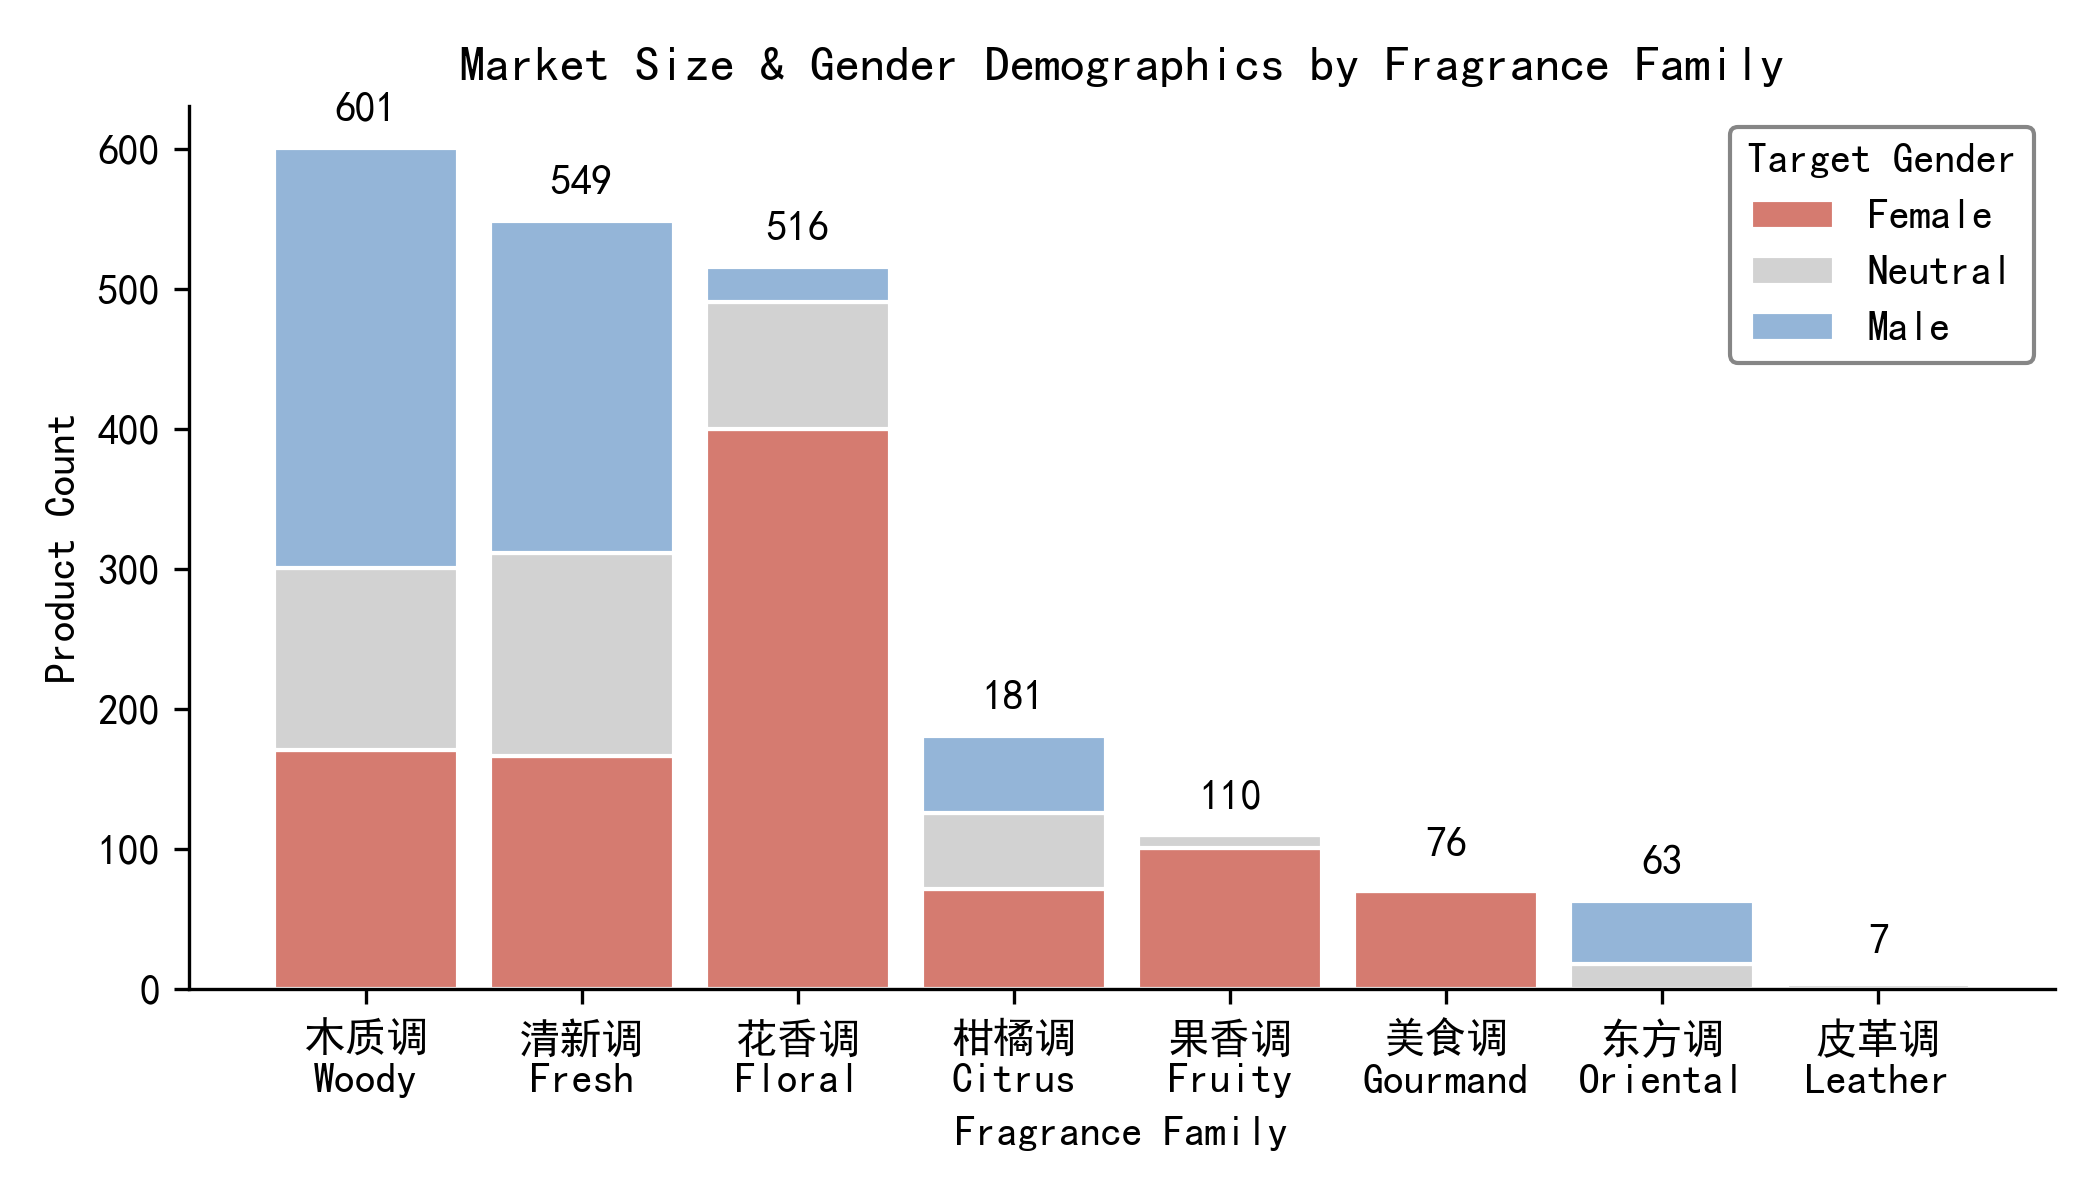

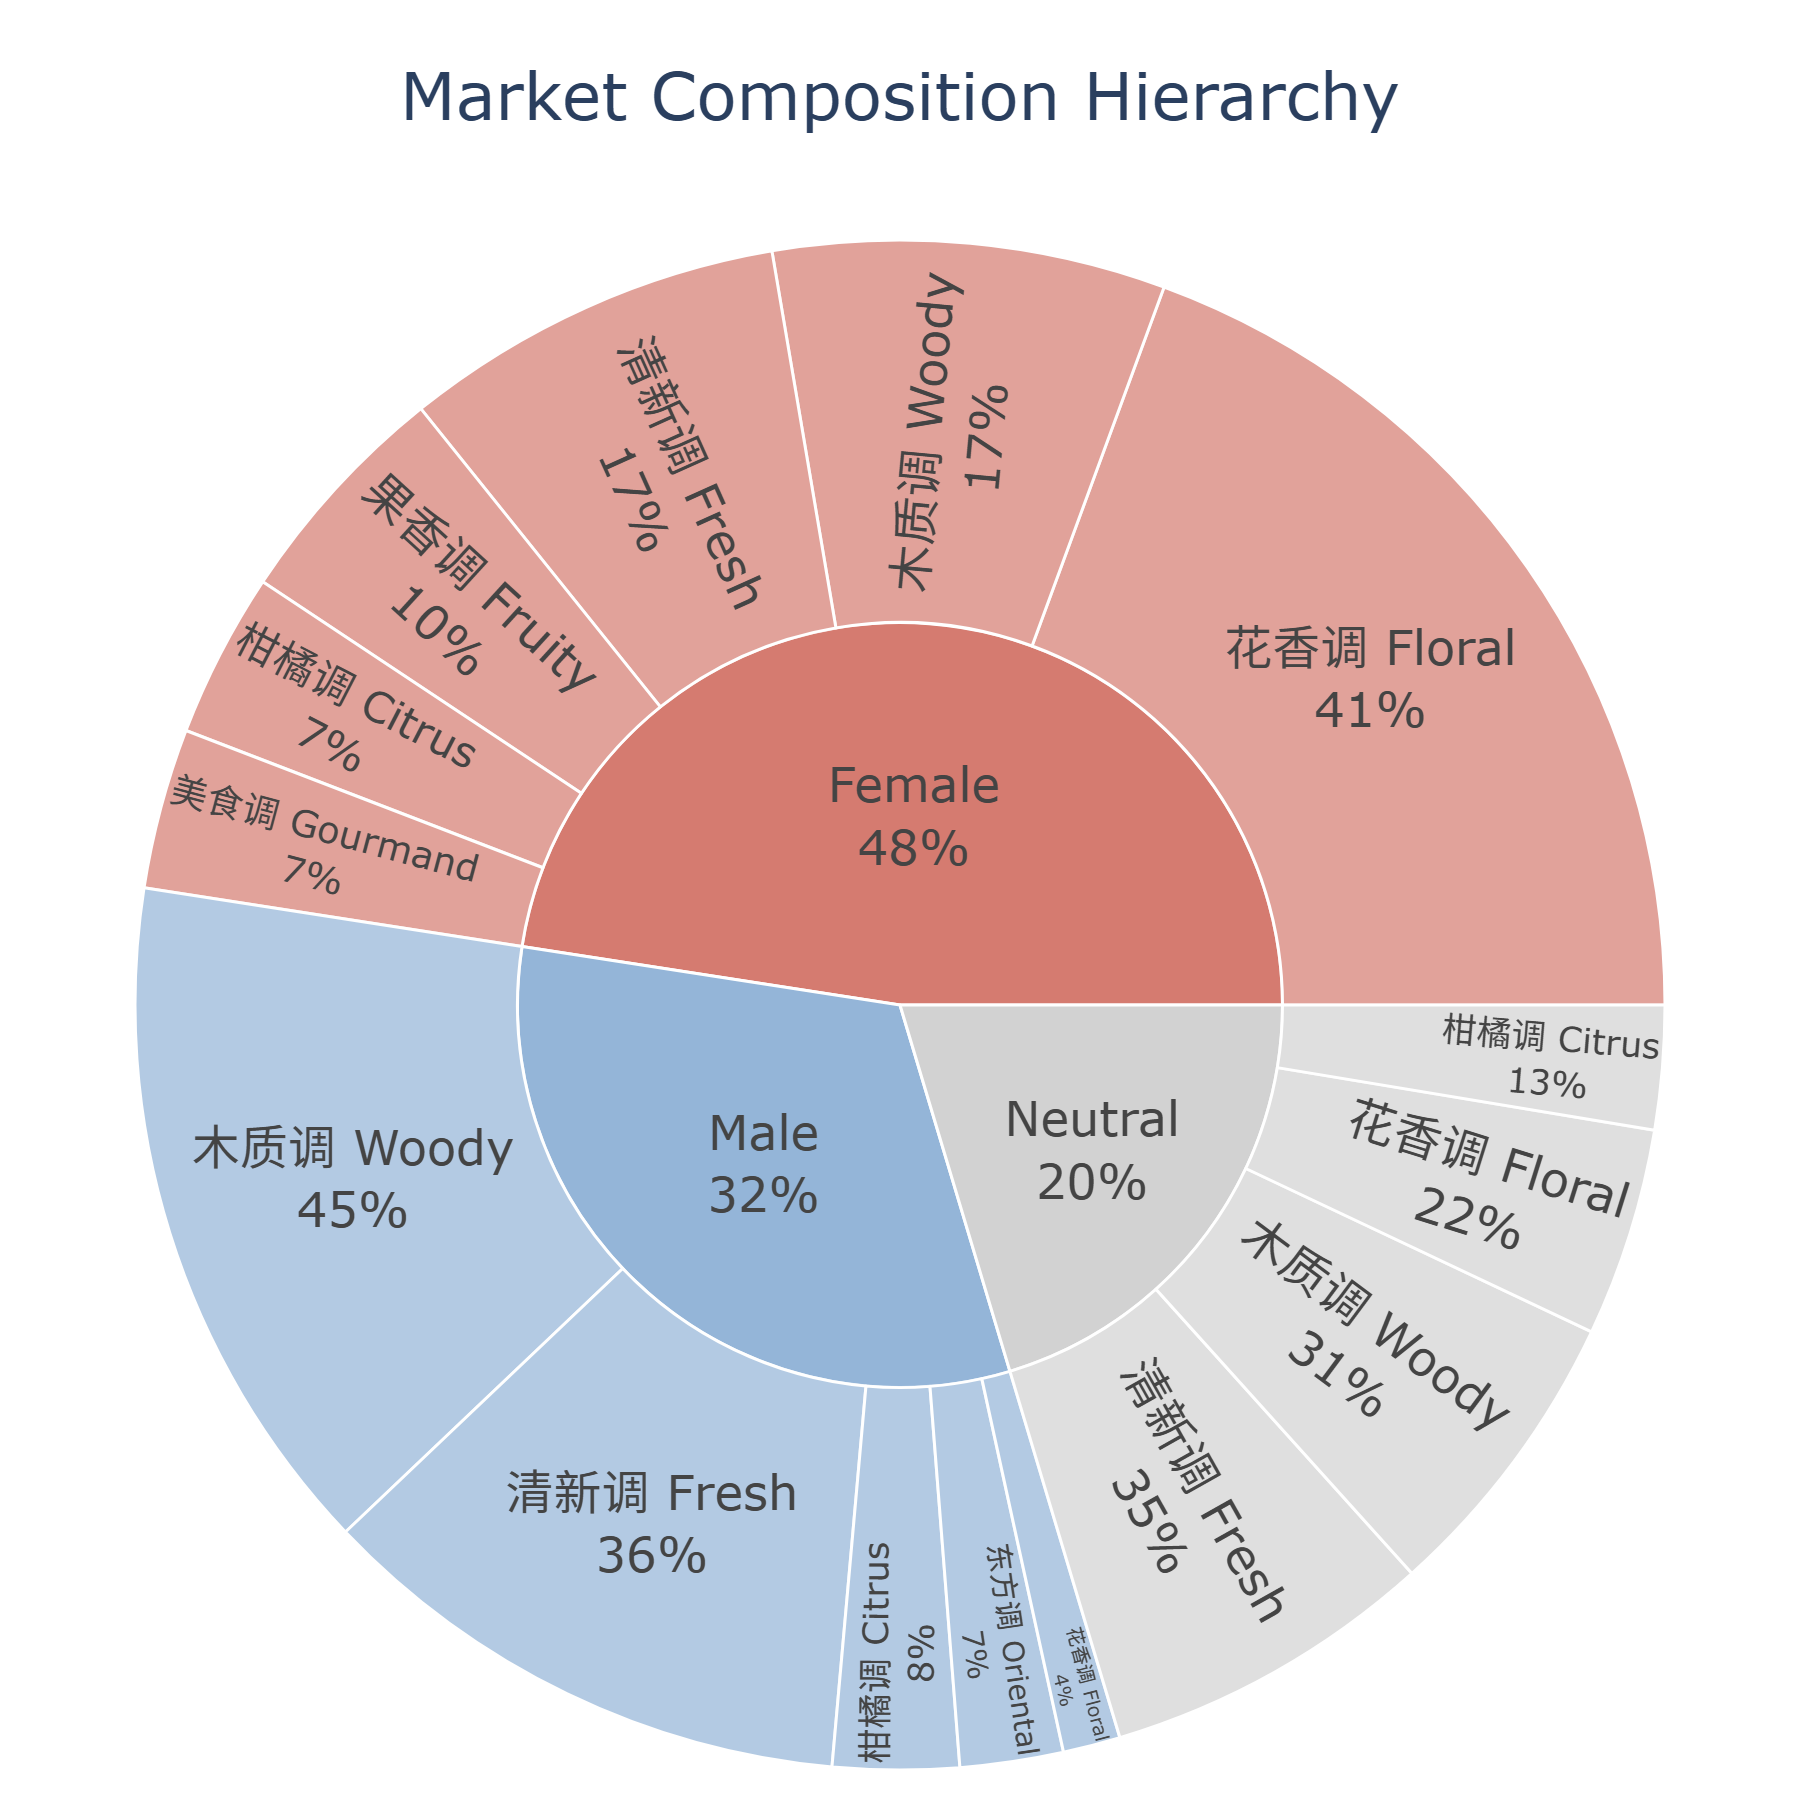

![Gender-Fragrance Preference Distribution Heatmap.png](<attachment:Gender-Fragrance Preference Distribution Heatmap.png>)
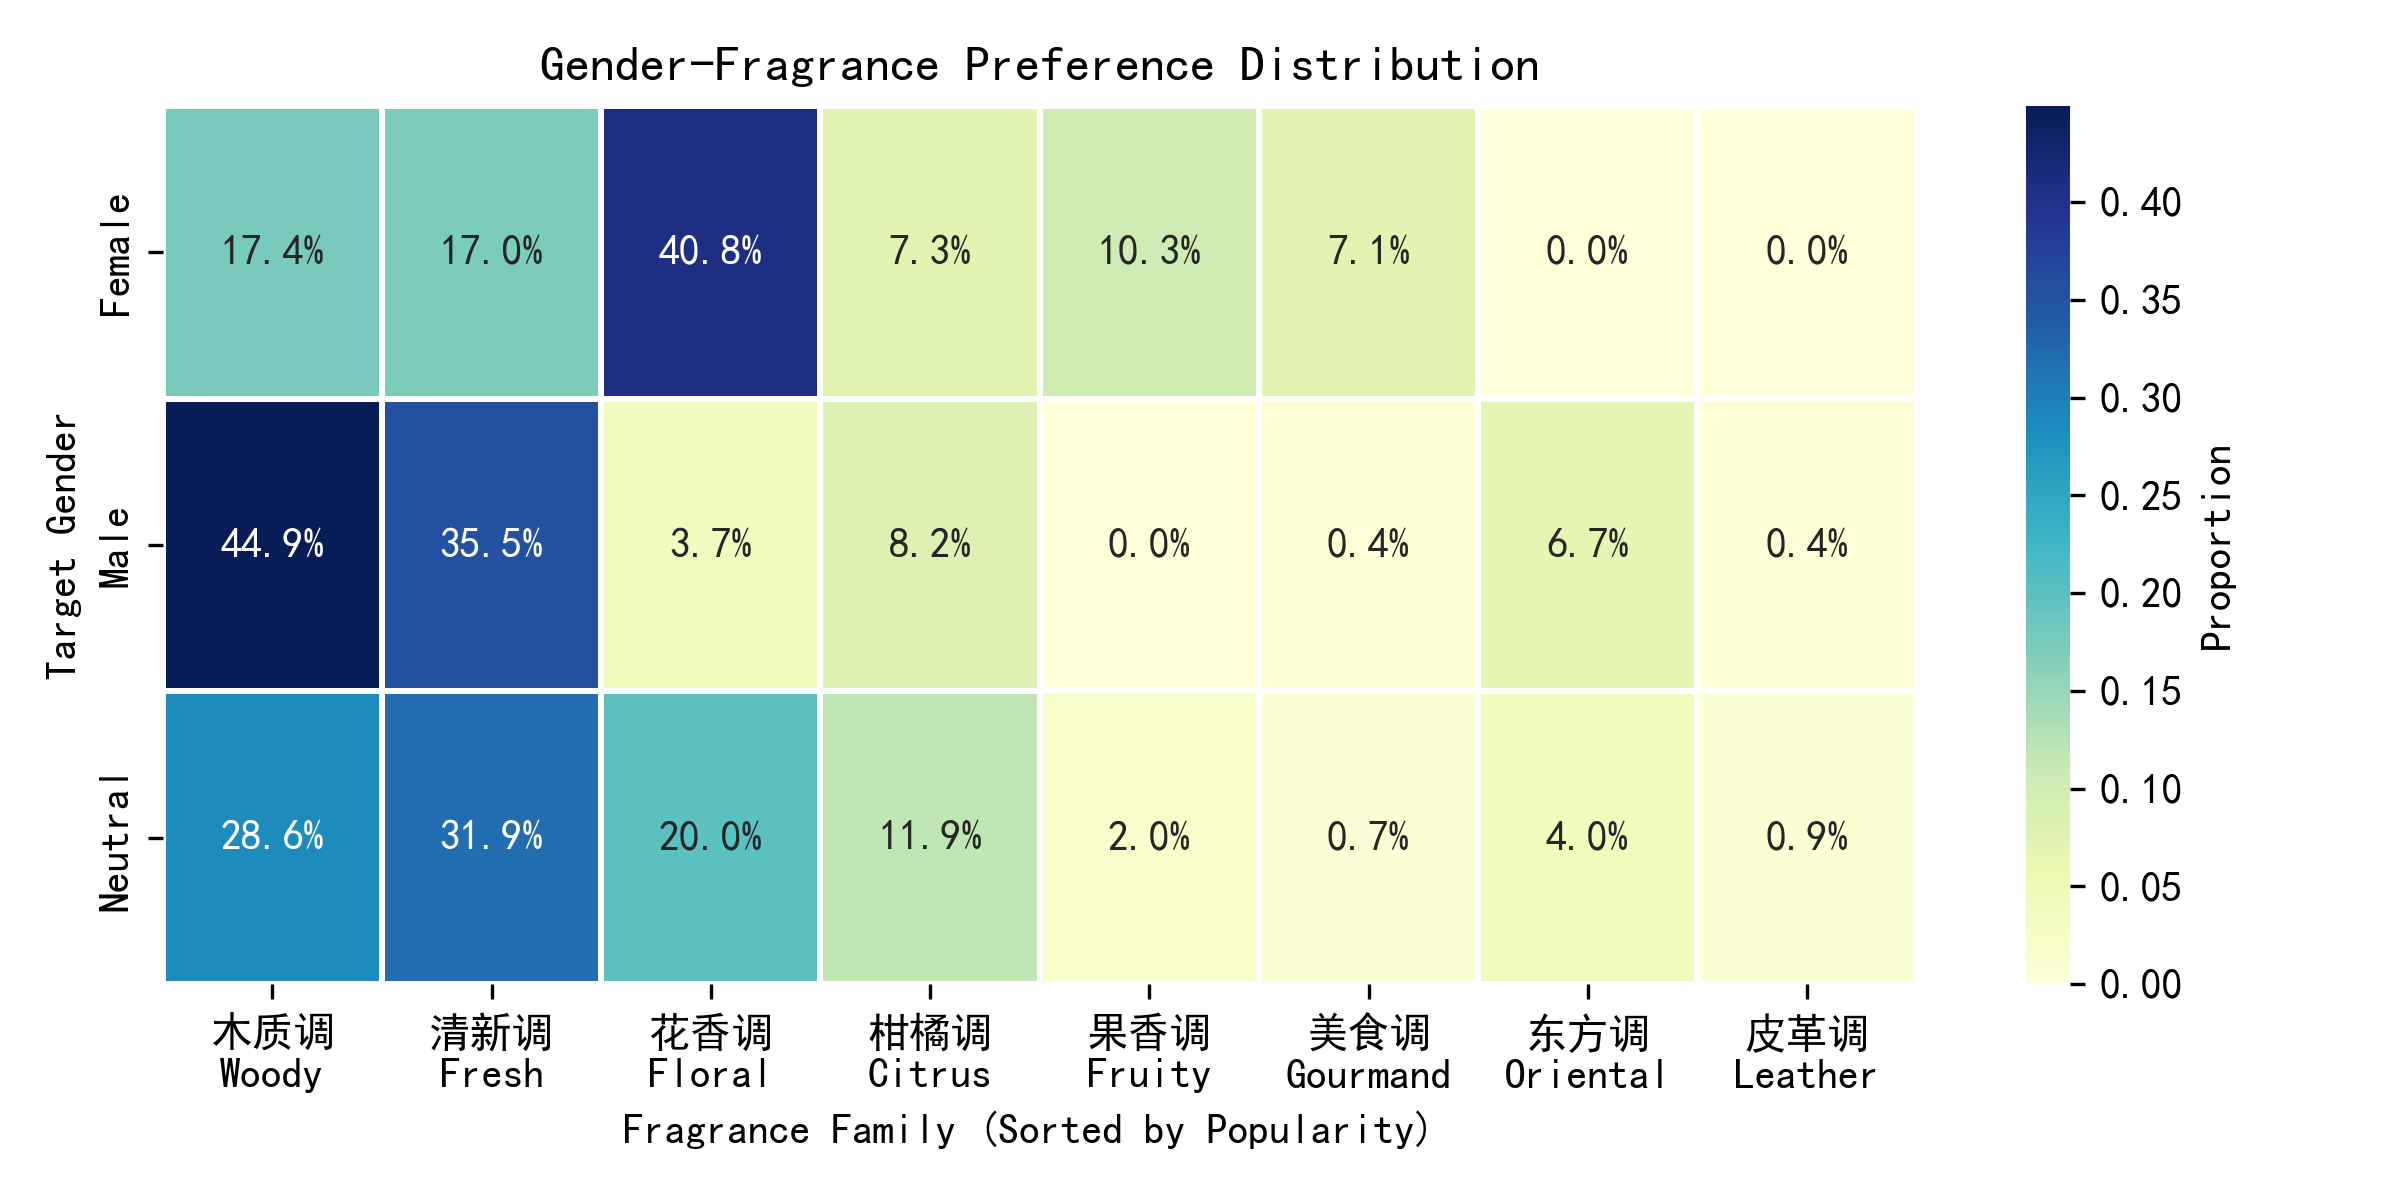

In [ ]:
# Fragrance Distribution by Gender Composition

plt.figure(figsize=(7, 4))

valid_genders = ['male', 'female', 'neutral']
df_stack = df_1976[df_1976['gender'].isin(valid_genders)].copy()

df_stack['fragrance_en'] = df_stack['fragrance'].map(class_trans).fillna(df_stack['fragrance'])

ct_stack = pd.crosstab(df_stack['fragrance_en'], df_stack['gender'])

ct_stack['Total'] = ct_stack.sum(axis=1)
ct_stack = ct_stack.sort_values('Total', ascending=False)

categories = ct_stack.index
genders_order = ['female', 'neutral', 'male'] 
data_bottom = np.zeros(len(categories))

colors = {'female': '#D57B70', 'neutral': '#D2D2D2', 'male': '#94B5D8'}
labels = {'female': 'Female', 'neutral': 'Neutral', 'male': 'Male'}

for gender in genders_order:
    if gender in ct_stack.columns:
        values = ct_stack[gender].values
        plt.bar(categories, values, bottom=data_bottom, label=labels[gender], 
                color=colors[gender], edgecolor='white', width=0.85, linewidth=1)
        data_bottom += values

plt.title('Market Size & Gender Demographics by Fragrance Family')
plt.xlabel('Fragrance Family')
plt.ylabel('Product Count')

plt.legend(title='Target Gender', loc='upper right', frameon=True, framealpha=0.95, shadow=False, edgecolor='gray')

for i, total in enumerate(ct_stack['Total']):
    plt.text(i, total + 15, f"{int(total)}", ha='center', va='bottom')

plt.grid(False)
sns.despine()
plt.tight_layout()
# plt.savefig("img/Market Size & Gender Demographics by Fragrance Family.png", dpi=300)
plt.show()

In [ ]:
# Market Composition Sunburst - Hierarchical View

df_sunburst = df_1976[df_1976['gender'].isin(['male', 'female', 'neutral'])].copy()

simple_trans_map = {k: v.split('\n')[0] + ' ' + v.split('\n')[1] for k, v in class_trans.items() if '\n' in v}
simple_trans_map.update({'male': 'Male', 'female': 'Female', 'neutral': 'Neutral'})

df_sunburst['gender_en'] = df_sunburst['gender'].map(simple_trans_map).fillna(df_sunburst['gender'])
df_sunburst['fragrance_en'] = df_sunburst['fragrance'].map(simple_trans_map).fillna(df_sunburst['fragrance'])

df_sb_count = df_sunburst.groupby(['gender_en', 'fragrance_en']).size().reset_index(name='count')
df_sb_count = df_sb_count[df_sb_count['count'] > 20]

fig = px.sunburst(
    df_sb_count, 
    path=['gender_en', 'fragrance_en'], 
    values='count',
    color='gender_en',
    color_discrete_map={
        'Female': '#D57B70',
        'Neutral': '#D2D2D2',
        'Male': '#94B5D8',
        '(?)': '#D2D2D2'
    },
    title='Market Composition Hierarchy'
)

fig.update_layout(
    width=600,
    height=600,
    margin=dict(t=80, l=10, r=10, b=10),
    font_size=16,
    template='plotly_white',
    title={'text': 'Market Composition Hierarchy', 'x': 0.5, 'xanchor': 'center'}
)
fig.update_traces(textinfo="label+percent parent")

# fig.write_image("img/Market_Composition_Sunburst.png", scale=3)
fig.show()


In [ ]:
# Gender-Fragrance Heatmap - Publication Quality
valid_genders = ['male', 'female', 'neutral']
df_heatmap = df_1976[df_1976['gender'].isin(valid_genders)].copy()

df_heatmap['fragrance_en'] = df_heatmap['fragrance'].map(class_trans).fillna(df_heatmap['fragrance'])
df_heatmap['gender_en'] = df_heatmap['gender'].map(class_trans).fillna(df_heatmap['gender'])

ct = pd.crosstab(df_heatmap['gender_en'], df_heatmap['fragrance_en'], normalize='index')

col_order = df_heatmap['fragrance_en'].value_counts().index
col_order = [c for c in col_order if c in ct.columns]
ct_sorted = ct[col_order]

plt.figure(figsize=(8, 4)) 

sns.heatmap(ct_sorted, annot=True, fmt='.1%', cmap='YlGnBu', 
            cbar_kws={'label': 'Proportion'},
            linewidths=1.0, linecolor='white')

plt.title('Gender-Fragrance Preference Distribution')
plt.xlabel('Fragrance Family (Sorted by Popularity) ')
plt.ylabel('Target Gender')

plt.tight_layout()
# plt.savefig("img/Gender-Fragrance Preference Distribution Heatmap.png", dpi=300)
plt.show()

## Core Ingredients & Market Penetration

In this section, we delve into the specific ingredients that make up these perfumes. In addition to calculating the frequency of each fragrance note across the entire dataset, we conducted a segmented analysis of the perfume's three-note structure (Top, Middle, and Base notes) to reveal the dominant scents at different stages.

**Overall & Structural Analysis:**
The analysis results indicate that **Musk** is the undisputed "King of Ingredients," appearing in 2,103 perfumes. It predominantly appears as a **Base Note**, providing depth and longevity to the fragrance.

Through the breakdown analysis of the three notes (Dominant Ingredients Analysis), we discovered clear structural patterns:
*   **Top Notes**: **Bergamot** (601 counts) and **Citrus** (310 counts) hold absolute dominance. Fresh, volatile citrus notes are the top choice for opening the olfactory experience, with Lemon and Pink Pepper also being common top note elements.
*   **Middle Notes**: Floral notes dominate the core experience. **Jasmine** (372 counts) and **Rose** (259 counts) are the most classic middle note choices, followed closely by **Neroli** and **Lavender**, constructing the main character of the perfume.
*   **Base Notes**: Besides **Musk**, **Patchouli**, **Amber**, and **Cedar** all have extremely high frequencies (400+ counts), forming the warm, woody foundation of modern perfumes.

**Keyword Cloud Analysis:**
The word cloud visualization intuitively displays the relative weight of these ingredients. We can see that in addition to the core ingredients mentioned above, elements like **Vanilla** and **Tonka Bean** also have significant visibility. This combination reveals a market trend: consumers generally prefer perfumes with a fresh opening (Bergamot/Citrus), a rich floral heart (Jasmine/Rose), and a warm, steady base (Musk/Woody/Amber).

The figures below display the ranking of the Top 20 ingredients, the detailed distribution of ingredients across the three notes, and the word cloud of overall ingredient frequency:

![Top-K Note Frequency Market Penetration Analysis.png](<attachment:Top-K Note Frequency Market Penetration Analysis.png>)
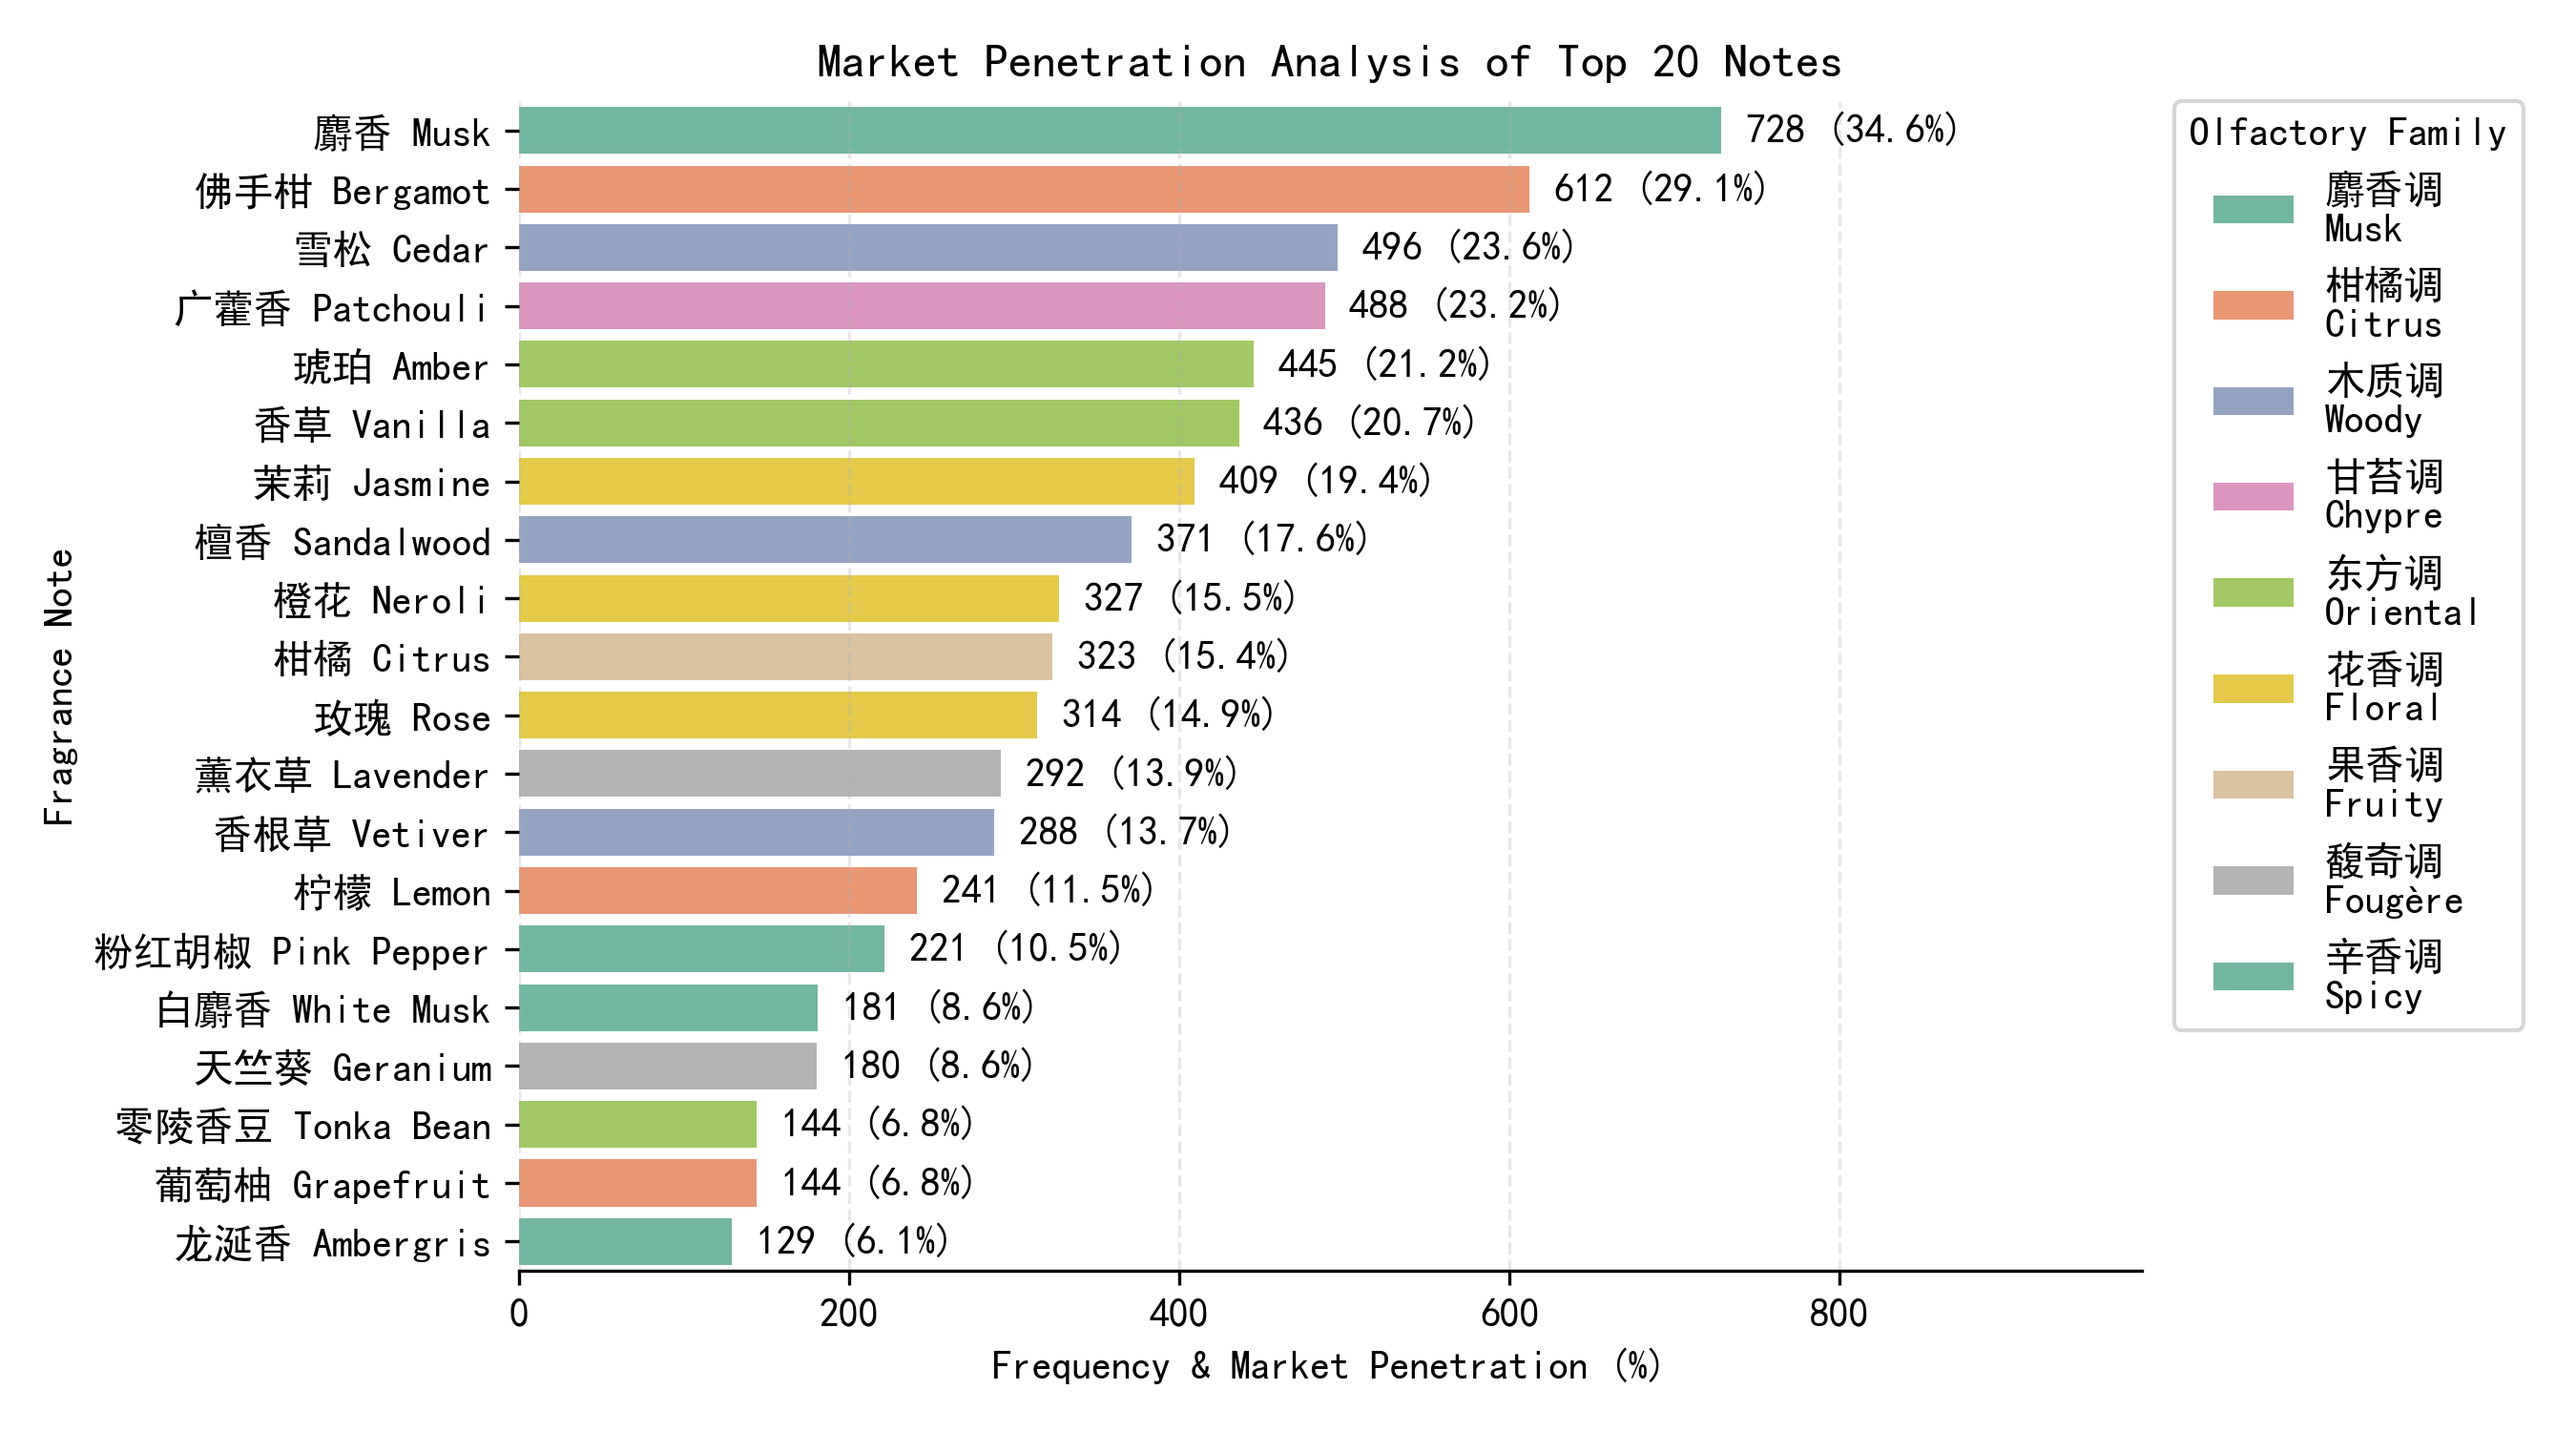

![Dominant Ingredients Analysis Top Middle Base Notes.png](<attachment:Dominant Ingredients Analysis Top Middle Base Notes.png>)
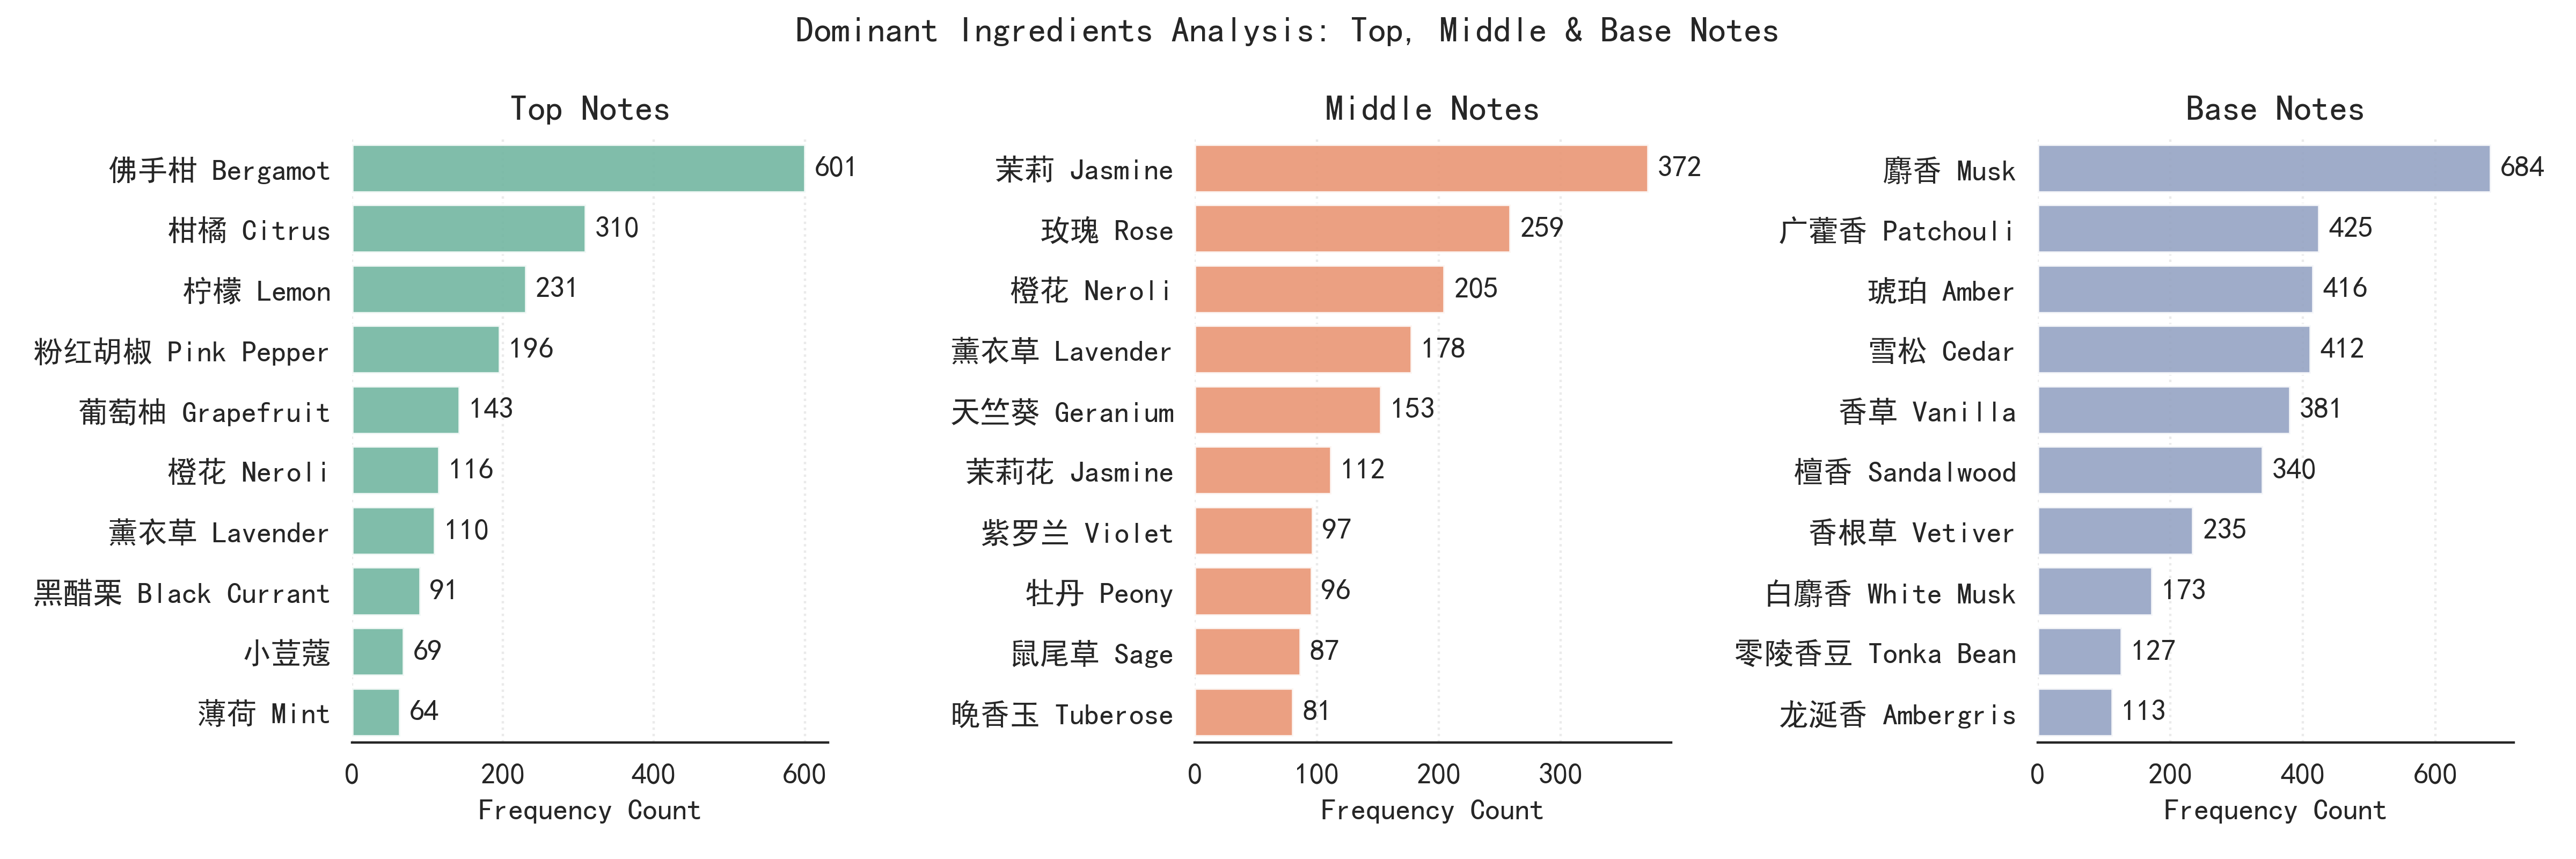

![Word Cloud of High-Frequency Fragrance Notes.png](<attachment:Word Cloud of High-Frequency Fragrance Notes.png>)
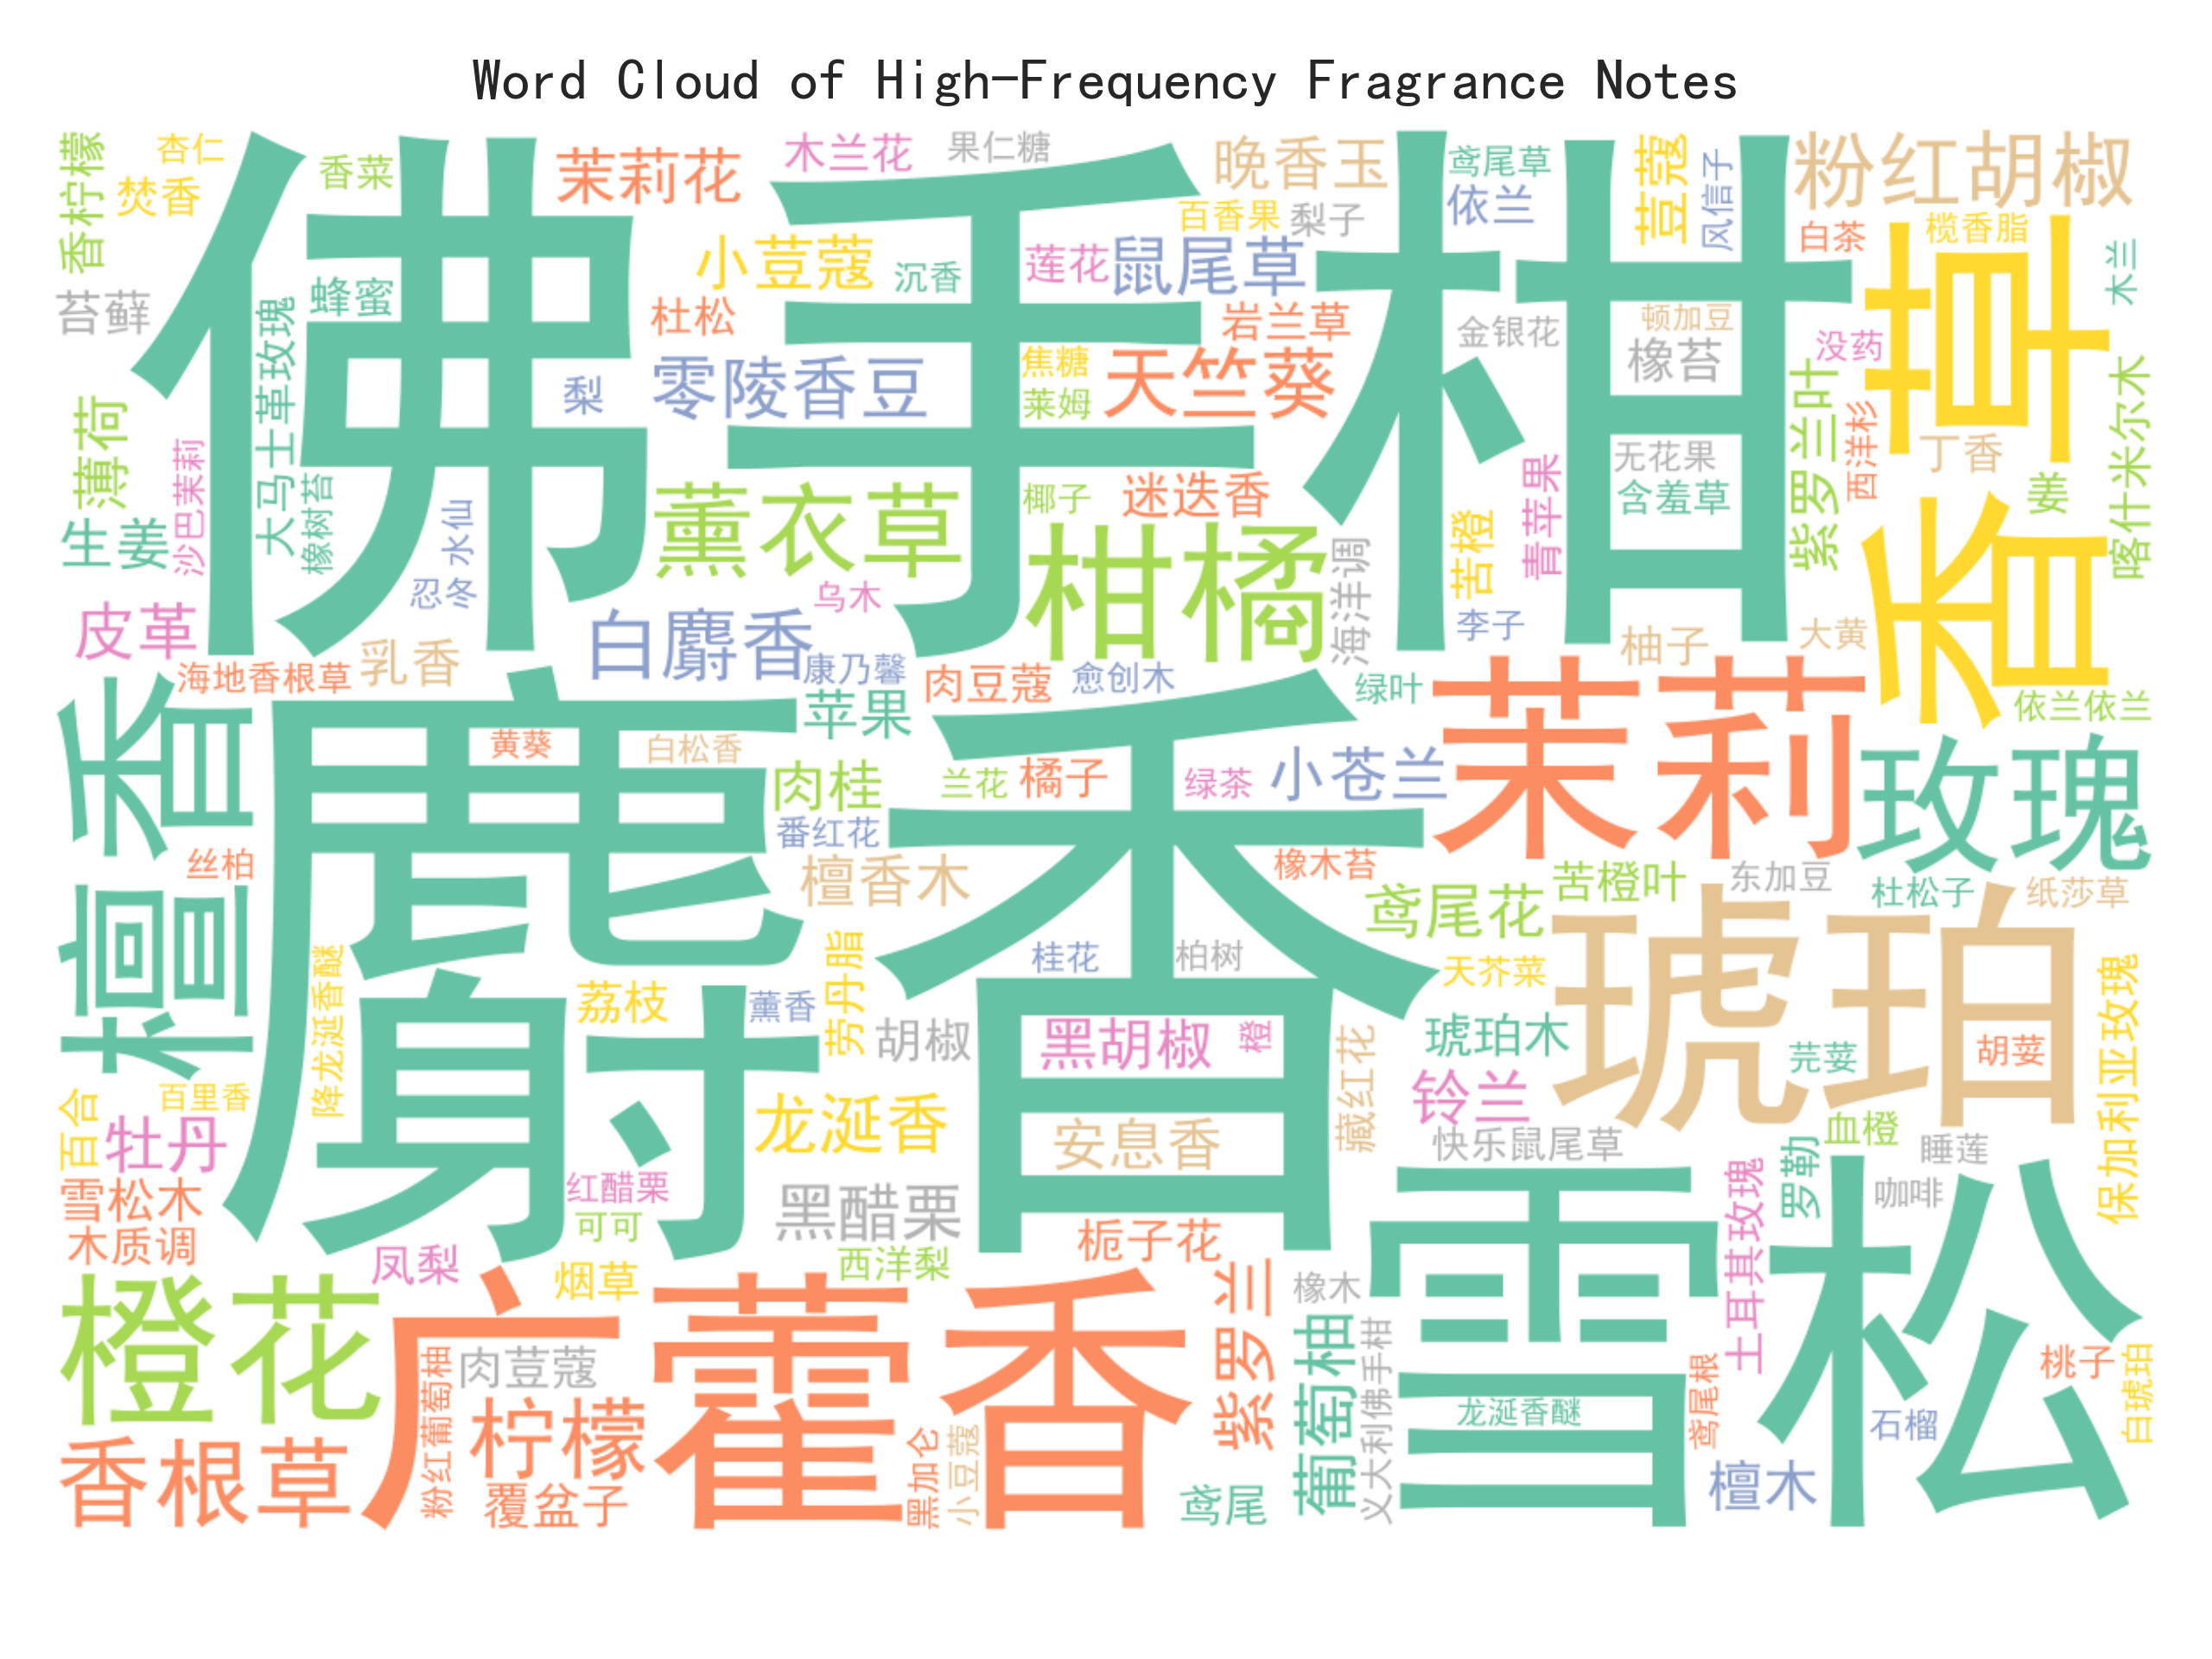

In [ ]:
# Note Frequency Top-K - Market Penetration Analysis

top_k = 20
total_perfumes = len(df_1976) 

df_top_notes = df_note_count.sort_values('count', ascending=False).head(top_k).copy()

note_trans = {
    '麝香': '麝香 Musk', '佛手柑': '佛手柑 Bergamot', '雪松': '雪松 Cedar', 
    '广藿香': '广藿香 Patchouli', '琥珀': '琥珀 Amber', '香草': '香草 Vanilla', 
    '茉莉': '茉莉 Jasmine', '檀香': '檀香 Sandalwood', '橙花': '橙花 Neroli', 
    '柑橘': '柑橘 Citrus', '玫瑰': '玫瑰 Rose', '薰衣草': '薰衣草 Lavender', 
    '香根草': '香根草 Vetiver', '柠檬': '柠檬 Lemon', '粉红胡椒': '粉红胡椒 Pink Pepper', 
    '白麝香': '白麝香 White Musk', '天竺葵': '天竺葵 Geranium', '零陵香豆': '零陵香豆 Tonka Bean', 
    '葡萄柚': '葡萄柚 Grapefruit', '龙涎香': '龙涎香 Ambergris'
}
df_top_notes['note_en'] = df_top_notes['note'].map(note_trans).fillna(df_top_notes['note'])

df_top_notes['class'] = df_top_notes['class'].fillna('Other')
df_top_notes['class_en'] = df_top_notes['class'].map(class_trans).fillna(df_top_notes['class'])

df_top_notes['percentage'] = df_top_notes['count'] / total_perfumes * 100 

plt.figure(figsize=(9, 5)) 

ax = sns.barplot(data=df_top_notes, y='note_en', x='count', hue='class_en', dodge=False, palette='Set2')

plt.title(f'Market Penetration Analysis of Top {top_k} Notes')
plt.xlabel('Frequency & Market Penetration (%)')
plt.ylabel('Fragrance Note')

plt.legend(title='Olfactory Family', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=True)

for i, p in enumerate(ax.patches):
    width = p.get_width()
    if width > 0: 
        percentage = (width / total_perfumes) * 100
        label_text = f'{int(width)} ({percentage:.1f}%)'
        ax.text(width + 15, p.get_y() + p.get_height()/2.,
                label_text,
                ha='left', va='center', color='black')

max_width = df_top_notes['count'].max()
plt.xlim(0, max_width * 1.35)

plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True, bottom=False)

plt.tight_layout()
# plt.savefig("img/Top-K Note Frequency Market Penetration Analysis.png", dpi=300)
plt.show()

In [ ]:
# Note Word Cloud

frequencies = df_note_count.set_index('note')['count'].to_dict()

font_path = 'C:/Windows/Fonts/simhei.ttf'
if not os.path.exists(font_path):
    import matplotlib.font_manager
    try:
        font_path = matplotlib.font_manager.findfont(matplotlib.font_manager.FontProperties(family=['SimHei']))
    except:
        font_path = None 

wc = WordCloud(
    font_path=font_path,
    background_color='white',
    width=1200,
    height=800,
    max_words=150,
    colormap='Set2',
    random_state=42,
    prefer_horizontal=0.9
)

wc.generate_from_frequencies(frequencies)

plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of High-Frequency Fragrance Notes')
plt.tight_layout()
# plt.savefig("img/Word Cloud of High-Frequency Fragrance Notes.png", dpi=400)
plt.show()

In [ ]:
# Top 10 Notes Distribution by Olfactory Pyramid Position

def get_note_counts(df, column):
    all_notes = []
    for notes in df[column].dropna():
        cleaned = notes.replace('、', ',').replace(' ', '')
        all_notes.extend([n.strip() for n in cleaned.split(',') if n.strip()])
    return pd.Series(Counter(all_notes)).sort_values(ascending=False)

top_counts = get_note_counts(df_1976, 'top_notes').head(10)
mid_counts = get_note_counts(df_1976, 'middle_notes').head(10)
base_counts = get_note_counts(df_1976, 'base_notes').head(10)

note_trans_map = {
    '麝香': '麝香 Musk', '佛手柑': '佛手柑 Bergamot', '雪松': '雪松 Cedar', 
    '广藿香': '广藿香 Patchouli', '琥珀': '琥珀 Amber', '香草': '香草 Vanilla', 
    '茉莉': '茉莉 Jasmine', '檀香': '檀香 Sandalwood', '橙花': '橙花 Neroli', 
    '柑橘': '柑橘 Citrus', '玫瑰': '玫瑰 Rose', '薰衣草': '薰衣草 Lavender', 
    '香根草': '香根草 Vetiver', '柠檬': '柠檬 Lemon', '粉红胡椒': '粉红胡椒 Pink Pepper', 
    '白麝香': '白麝香 White Musk', '天竺葵': '天竺葵 Geranium', '零陵香豆': '零陵香豆 Tonka Bean', 
    '葡萄柚': '葡萄柚 Grapefruit', '龙涎香': '龙涎香 Ambergris', '依兰': '依兰 Ylang-Ylang',
    '紫罗兰': '紫罗兰 Violet', '鸢尾花': '鸢尾花 Iris', '橡木苔': '橡木苔 Oakmoss',
    '安息香': '安息香 Benzoin', '皮革': '皮革 Leather', '黑胡椒': '黑胡椒 Black Pepper',
    '肉豆蔻': '肉豆蔻 Nutmeg', '小豆蔻': '小豆蔻 Cardamom', '生姜': '生姜 Ginger',
    '薄荷': '薄荷 Mint', '罗勒': '罗勒 Basil', '鼠尾草': '鼠尾草 Sage',
    '百合': '百合 Lily', '铃兰': '铃兰 Lily of the Valley', '晚香玉': '晚香玉 Tuberose',
    '桃子': '桃子 Peach', '苹果': '苹果 Apple', '黑醋栗': '黑醋栗 Black Currant',
    '梨': '梨 Pear', '菠萝': '菠萝 Pineapple', '椰子': '椰子 Coconut',
    '橘子': '橘子 Mandarin', '沉香': '沉香 Oud', '劳丹脂': '劳丹脂 Labdanum',
    '牡丹': '牡丹 Peony', '小苍兰': '小苍兰 Freesia', '香柠檬': '香柠檬 Bergamot',
    '茉莉花': '茉莉花 Jasmine', '檀香木': '檀香木 Sandalwood', '檀木': '檀木 Sandalwood',
    '雪松木': '雪松木 Cedar', '橡苔': '橡苔 Oakmoss', '乳香': '乳香 Frankincense',
    '没药': '没药 Myrrh', '鸢尾': '鸢尾 Iris', '水蜜桃': '水蜜桃 Peach',
    '杏': '杏 Apricot', '黑加仑': '黑加仑 Blackcurrant', '肉桂': '肉桂 Cinnamon',
    '丁香': '丁香 Clove', '芫荽': '芫荽 Coriander', '丝柏': '丝柏 Cypress',
    '尤加利': '尤加利 Eucalyptus', '无花果': '无花果 Fig', '栀子花': '栀子花 Gardenia',
    '风信子': '风信子 Hyacinth', '杜松子': '杜松子 Juniper Berry', '青柠': '青柠 Lime',
    '木兰': '木兰 Magnolia', '苔藓': '苔藓 Moss', '桂花': '桂花 Osmanthus',
    '李子': '李子 Plum', '藏红花': '藏红花 Saffron', '烟草': '烟草 Tobacco',
    '柚子': '柚子 Yuzu', '香柠檬': '香柠檬 Bergamot'
}

sns.set_style("white")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

positions = ['Top Notes', 'Middle Notes', 'Base Notes']
data_list = [top_counts, mid_counts, base_counts]

colors = ['#66C2A5', '#FC8D62', '#8DA0CB'] 

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.4)

for i, (ax, data, title, color) in enumerate(zip(axes, data_list, positions, colors)):
    labels = [note_trans_map.get(n, n) for n in data.index]

    bars = sns.barplot(x=data.values, y=labels, ax=ax, color=color, alpha=0.9)

    ax.set_title(title)
    ax.set_xlabel('Frequency Count')
    ax.tick_params(axis='y')
    ax.tick_params(axis='x')

    for p in ax.patches:
        width = p.get_width()
        ax.text(width + max(data.values)*0.02, p.get_y() + p.get_height()/2, 
                f'{int(width)}', ha='left', va='center')
    
    # Remove borders
    sns.despine(left=True, bottom=False, ax=ax)
    
    # Add light grid for readability
    ax.grid(axis='x', linestyle=':', alpha=0.4)
    ax.set_ylabel('') # Remove y-label as it's self-explanatory

plt.suptitle('Dominant Ingredients Analysis: Top, Middle & Base Notes')
plt.tight_layout()
# plt.savefig("img/Dominant Ingredients Analysis Top Middle Base Notes.png", dpi=400)
plt.show()

## Olfactory Structure & Complexity

Finally, we turn our attention to the internal structure of perfumes, using Sankey Diagrams and Boxplots to explore the flow path of scents and formula complexity.

**Olfactory Flow Path:**
The Sankey diagram vividly illustrates the evolutionary logic of perfumes from **Top -> Middle -> Base notes**.
*   **Classic Path**: The most prominent flow path starts with **Citrus/Fruity** notes, transitions to a **Floral** core, and finally settles into a **Musk/Woody** base. This "Fresh-Soft-Warm" three-stage structure constitutes the mainstream skeleton of modern commercial perfumes.
*   **Structural Differences**: We observe that male perfumes tend towards the hard lines of "Citrus -> Aromatic/Spicy -> Woody", while female perfumes present more of the soft curves of "Fruity -> Floral -> Musk/Amber".
*   **Neutral Aesthetics**: Neutral perfumes showcase a unique beauty of balance, often opening with fresh **Citrus** or **Green** notes, blending **Floral** and **Woody** characteristics in the middle, and finally returning to the steadiness of **Musk** or **Woody** notes, breaking the traditional olfactory boundaries of gender.

**Formula Complexity:**
We measure "complexity" by calculating the number of ingredients contained in each perfume and use boxplots to compare the formula richness of different fragrance families.
*   **Spectrum of Complexity**: **Chypre** and **Oriental** notes typically possess the highest median number of ingredients, representing the traditional aesthetic of grand structures and rich layers.
*   **Minimalism**: In contrast, **Fresh** notes or single floral perfumes have simpler formulas, emphasizing the purity of a single element.
*   **Dispersion**: The distribution range of the boxplot also reveals that certain fragrance families (such as Woody notes) have great elasticity in formula complexity, ranging from minimalist modern works to complex classical pieces.

The figures below display the Sankey diagram of the three-note flow and the complexity distribution of different fragrance types:

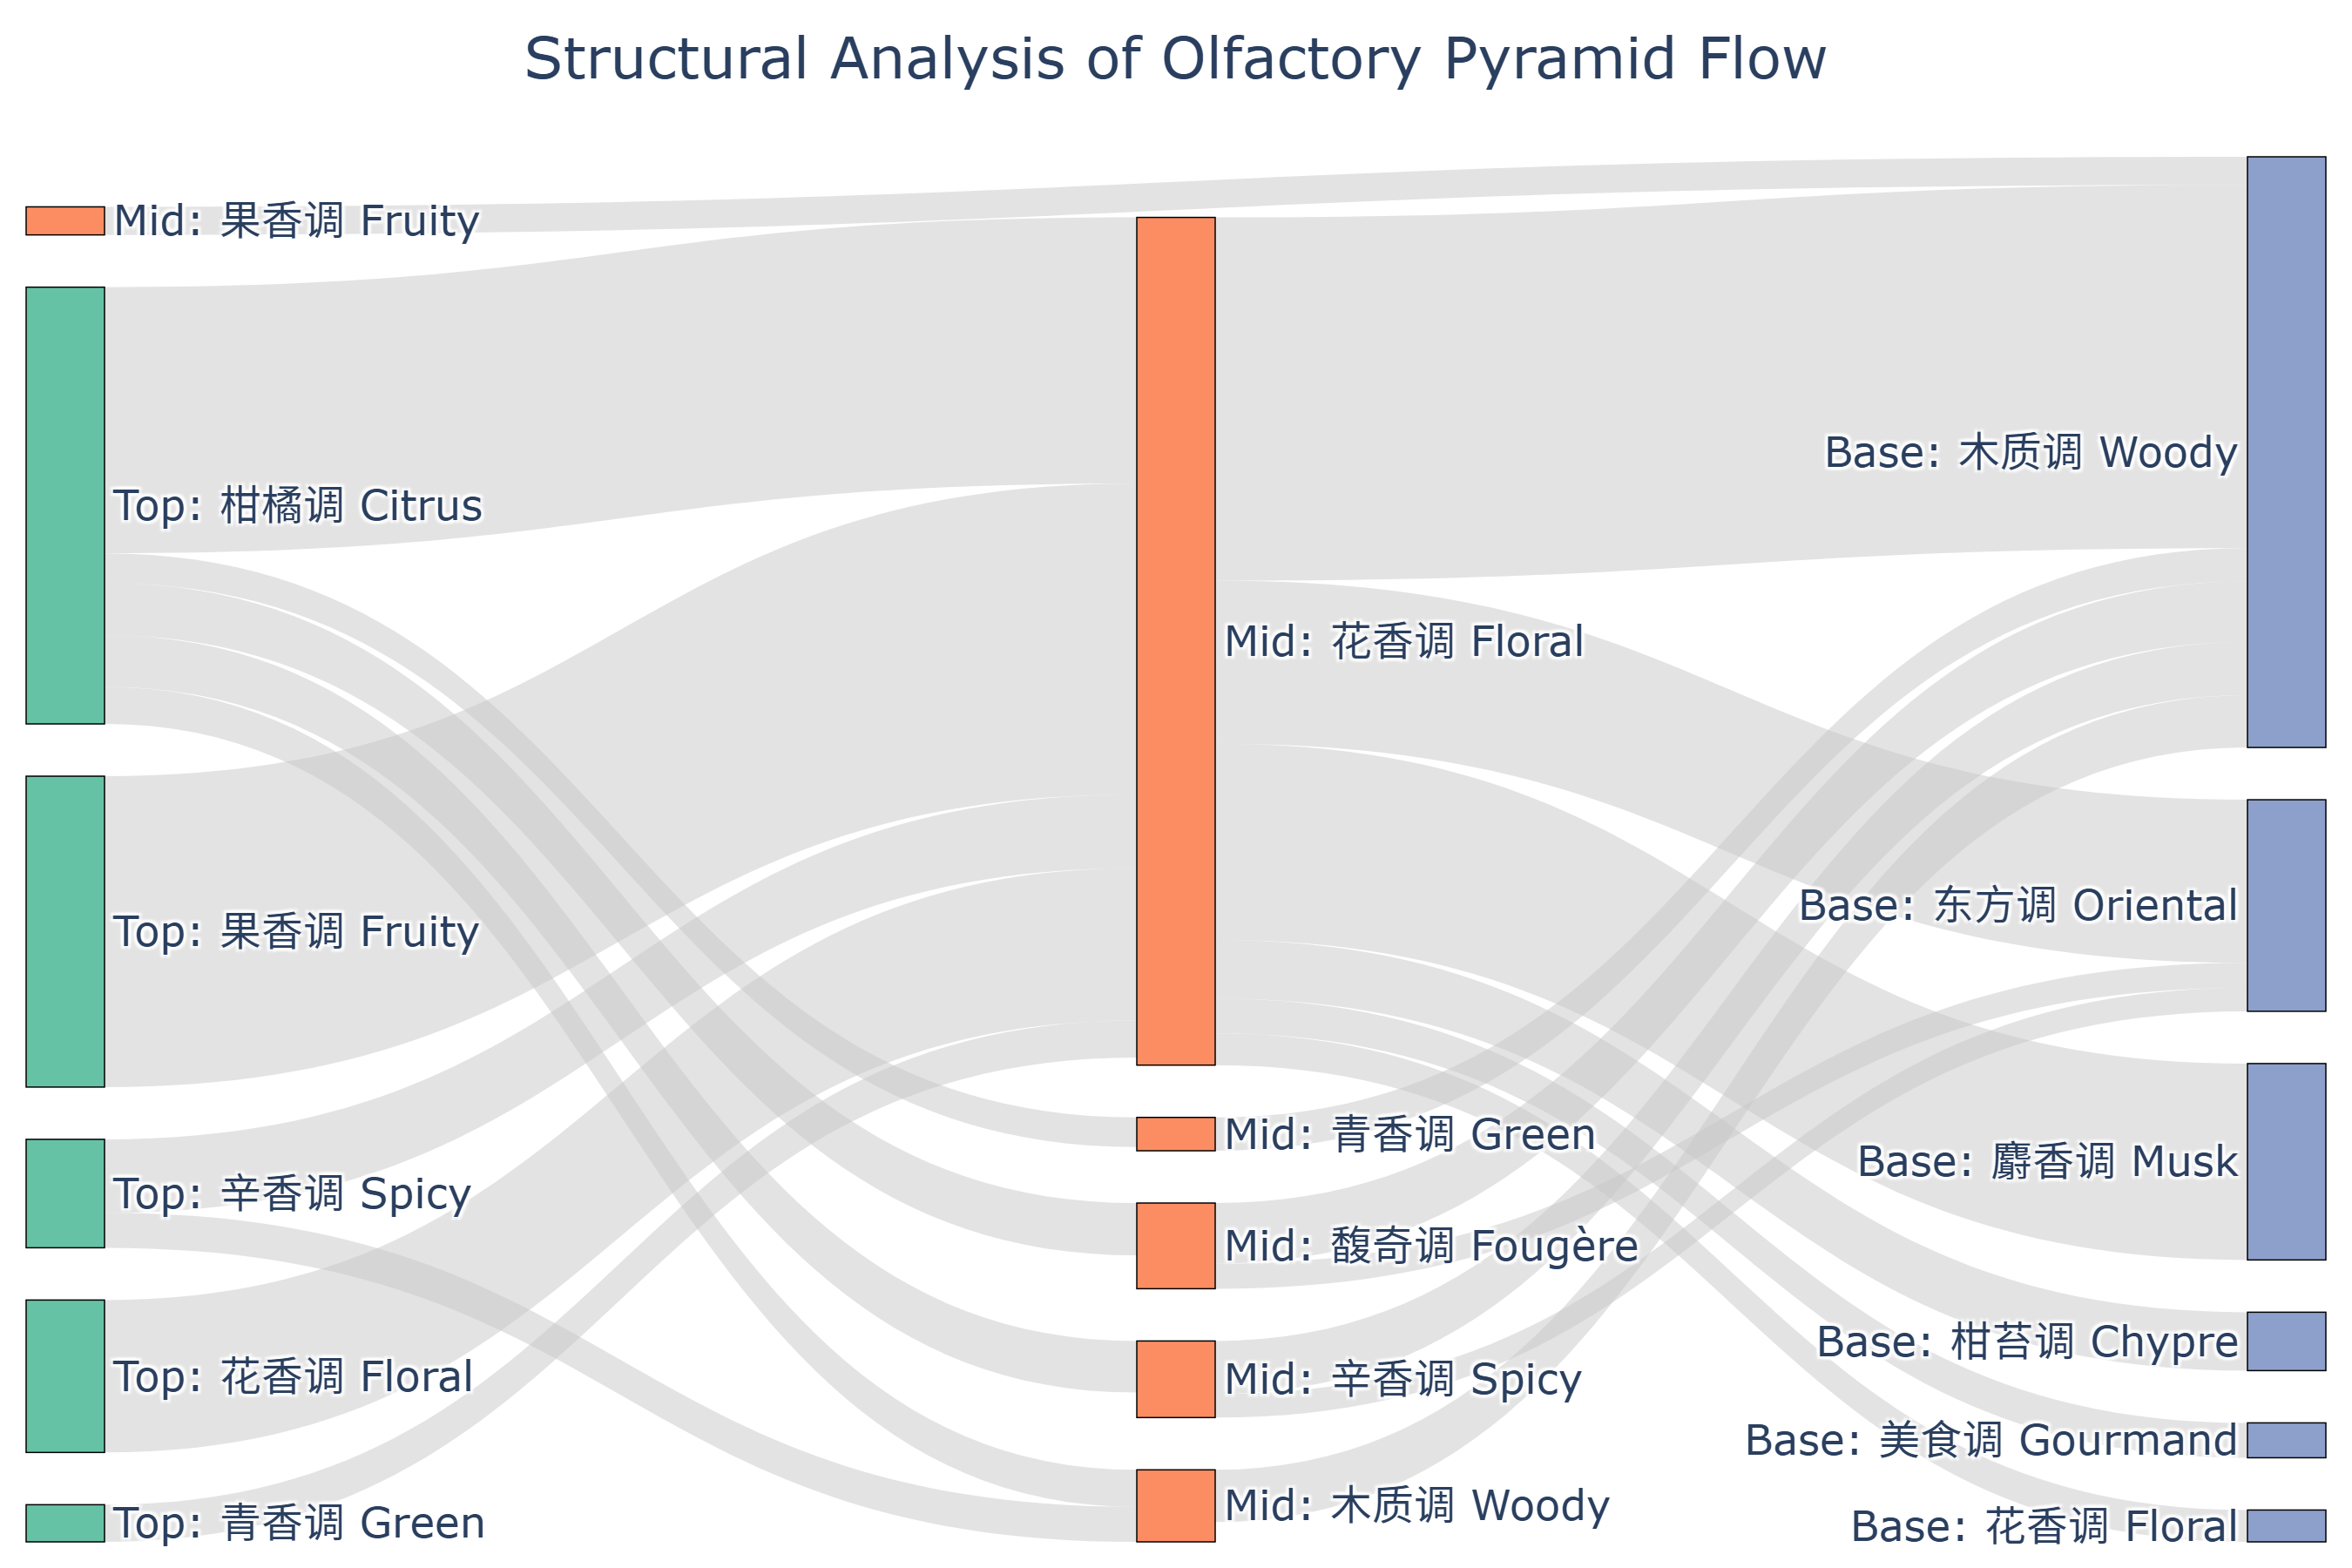

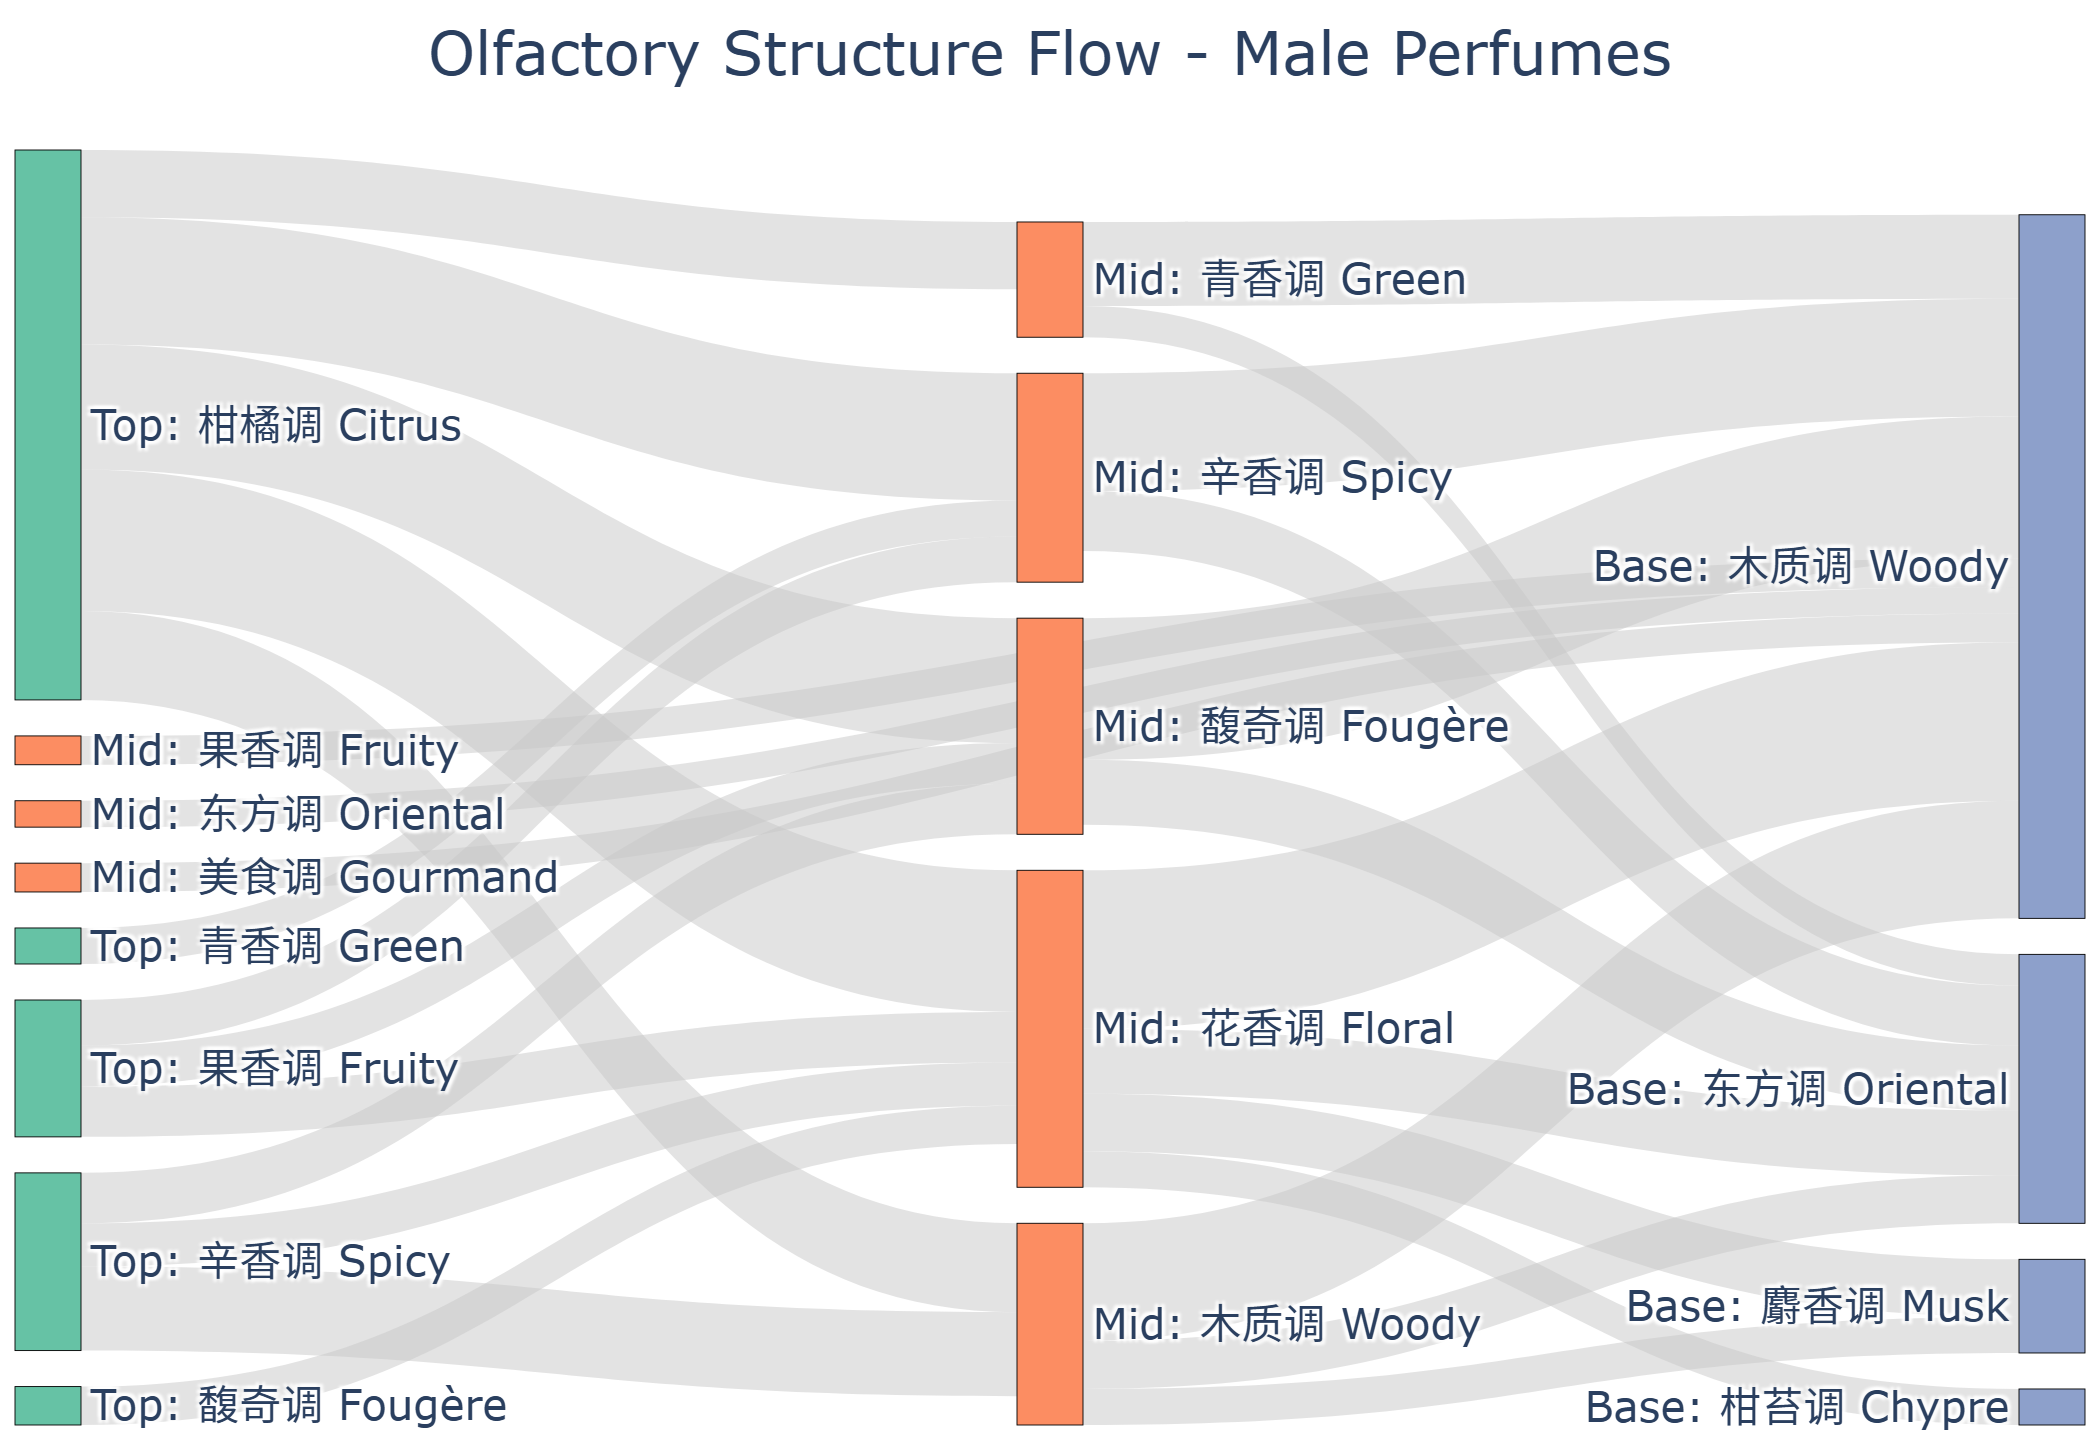

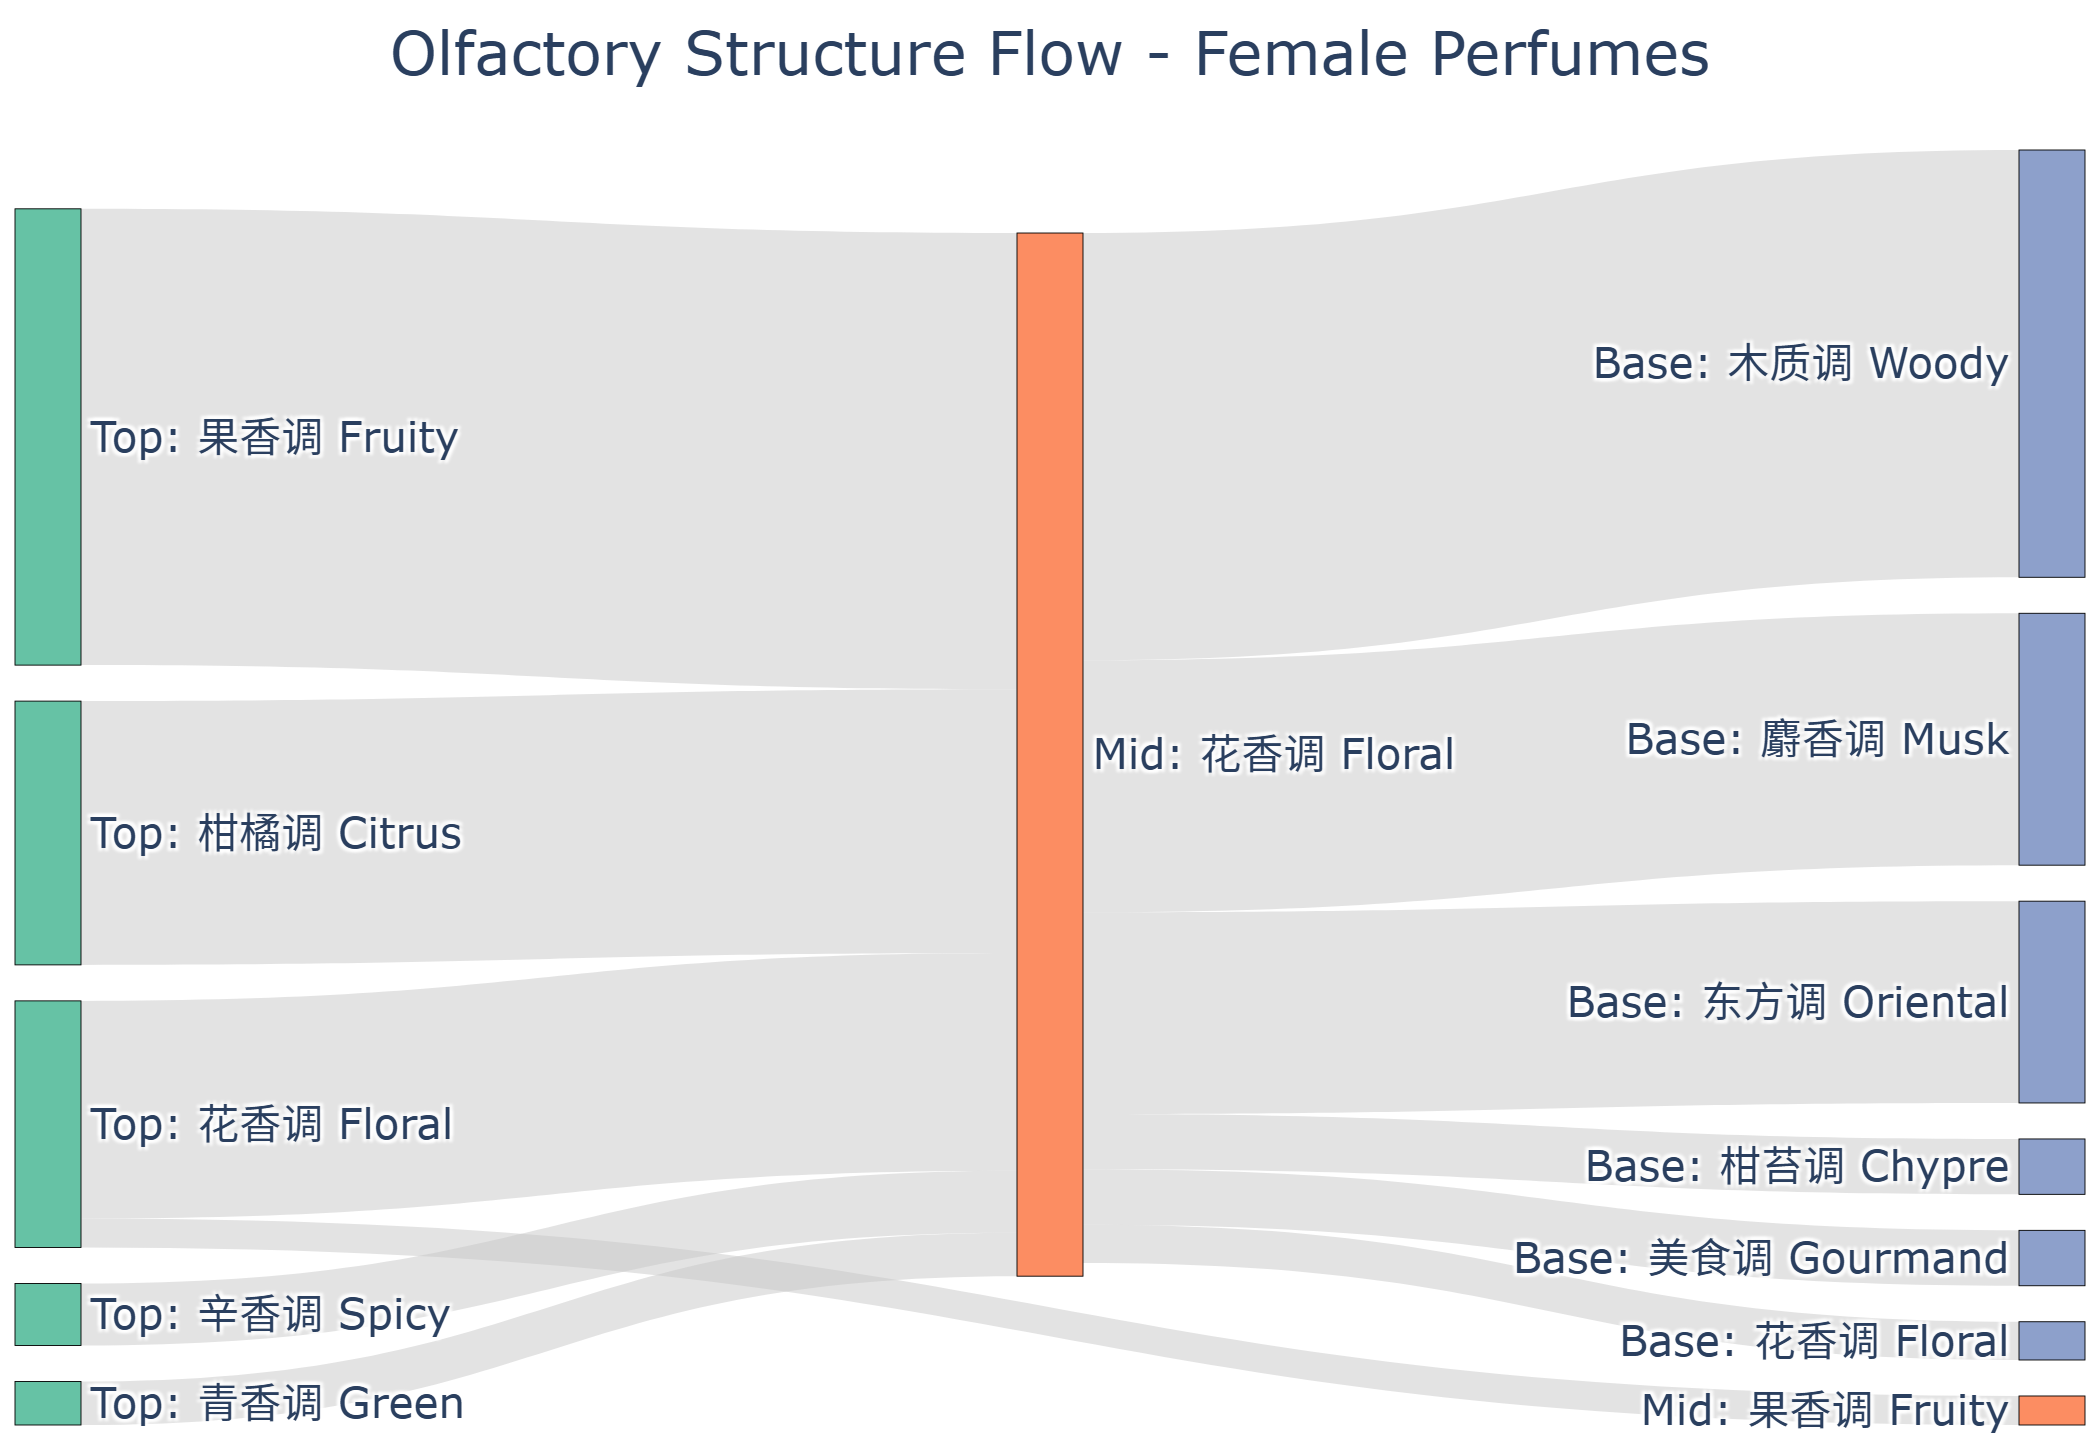

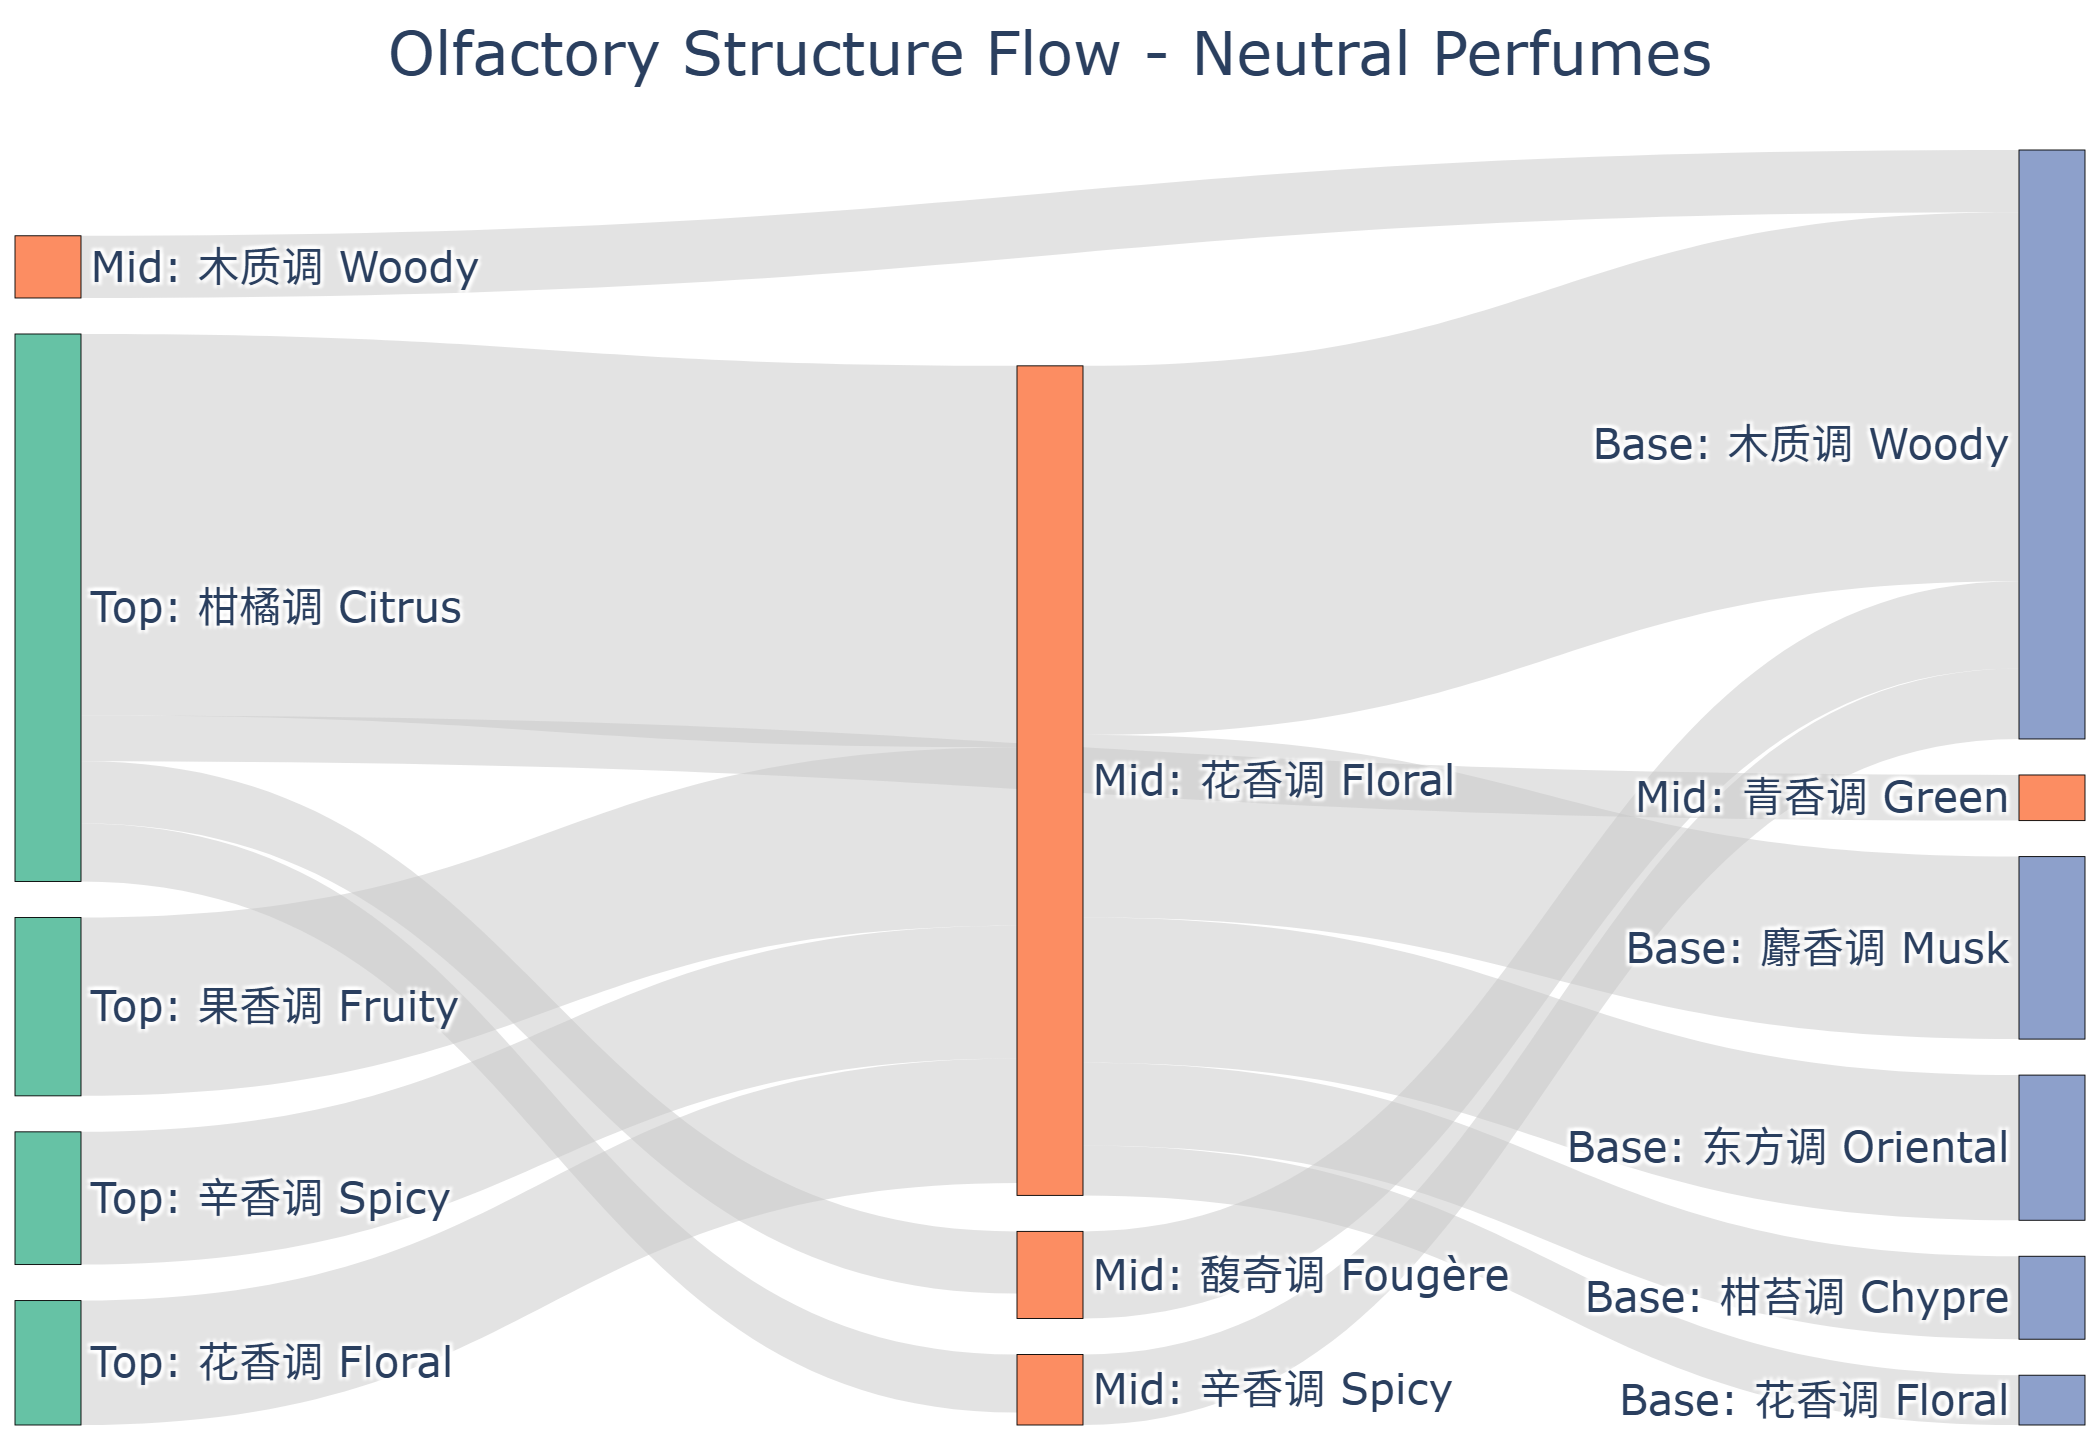

![Complexity Analysis Note Richness by Fragrance Family.png](<attachment:Complexity Analysis Note Richness by Fragrance Family.png>)
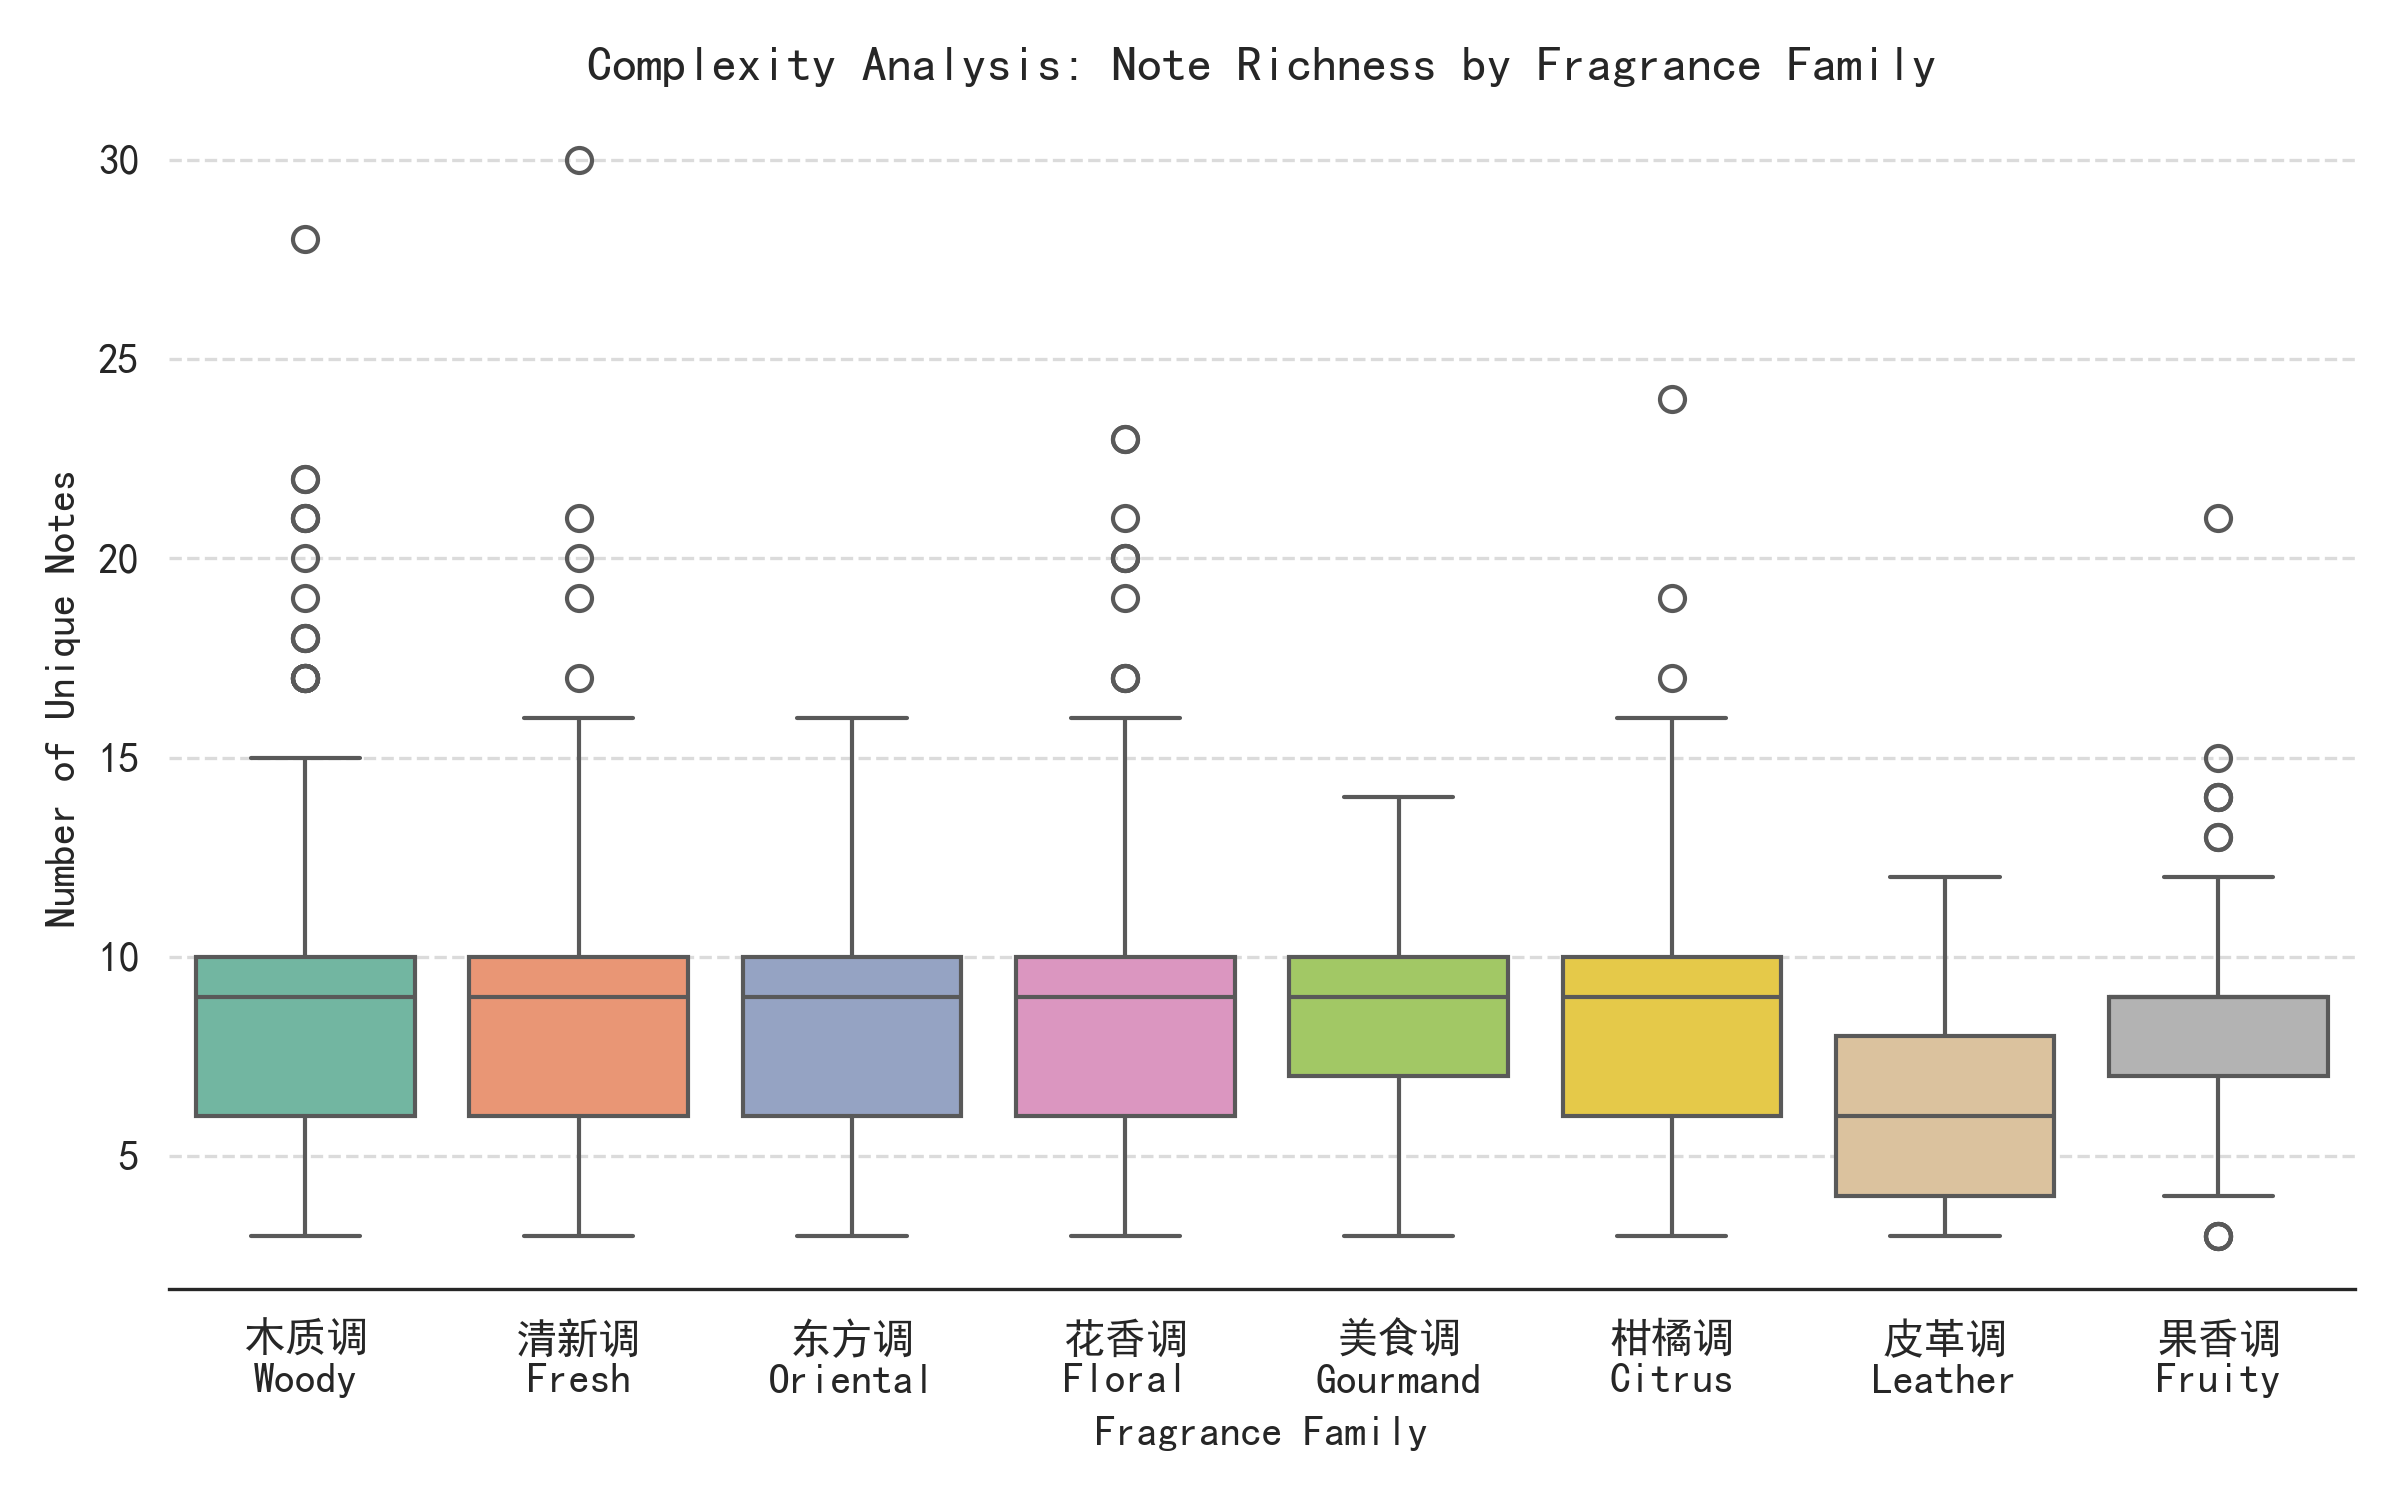

In [ ]:
# Sankey Diagram - Olfactory Pyramid Structure Analysis
def get_dominant_class_en(notes_str):
    if pd.isna(notes_str): return None
    notes = [n.strip() for n in notes_str.replace('、', ',').split(',')]
    classes = [note_class_map.get(n, '其他') for n in notes]
    if not classes: return 'Other'
    dom_class = Counter(classes).most_common(1)[0][0]
    trans_map = {
        '花香调': '花香调 Floral', '木质调': '木质调 Woody', '东方调': '东方调 Oriental', 
        '柑橘调': '柑橘调 Citrus', '果香调': '果香调 Fruity', '馥奇调': '馥奇调 Fougère', 
        '绿叶调': '绿叶调 Green', '水生调': '水生调 Aquatic', '甘苔调': '甘苔调 Chypre', 
        '皮革调': '皮革调 Leather', '美食调': '美食调 Gourmand', '辛香调': '辛香调 Spicy',
        '醛香调': '醛香调 Aldehyde', '素心兰调': '素心兰调 Chypre', '清新调': '清新调 Fresh', 
        '其他': '其他 Other',
        '木质香调': '木质调 Woody', '美食香调': '美食调 Gourmand', '皮革香调': '皮革调 Leather', 
        '青香调': '青香调 Green', '海洋调': '海洋调 Marine', '麝香调': '麝香调 Musk', 
        '柑苔香调': '柑苔调 Chypre', '树脂调': '树脂调 Resinous', '概念性': '概念性 Conceptual'
    }
    if dom_class not in trans_map and dom_class in class_trans:
        val = class_trans[dom_class]
        if '\n' in val:
            trans_map[dom_class] = val.replace('\n', ' ')
    return trans_map.get(dom_class, dom_class)

sankey_data = []
for _, row in df_1976.iterrows():
    top = get_dominant_class_en(row['top_notes'])
    mid = get_dominant_class_en(row['middle_notes'])
    base = get_dominant_class_en(row['base_notes'])
    if top and mid:
        sankey_data.append({'source': f"Top: {top}", 'target': f"Mid: {mid}", 'value': 1})
    if mid and base:
        sankey_data.append({'source': f"Mid: {mid}", 'target': f"Base: {base}", 'value': 1})

df_sankey = pd.DataFrame(sankey_data)
df_sankey = df_sankey.groupby(['source', 'target']).count().reset_index()
df_sankey = df_sankey[df_sankey['value'] > 30] 

all_nodes = list(pd.concat([df_sankey['source'], df_sankey['target']]).unique())
node_map = {node: i for i, node in enumerate(all_nodes)}
node_colors = ["#66c2a5" if "Top" in n else "#fc8d62" if "Mid" in n else "#8da0cb" for n in all_nodes]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 30,
      line = dict(color = "black", width = 0.5),
      label = all_nodes,
      color = node_colors
    ),
    link = dict(
      source = [node_map[s] for s in df_sankey['source']],
      target = [node_map[t] for t in df_sankey['target']],
      value = df_sankey['value'],
      color = "rgba(200, 200, 200, 0.5)" 
  ))])

fig.update_layout(
    title={'text': "Structural Analysis of Olfactory Pyramid Flow", 'x': 0.5, 'xanchor': 'center'},
    font_size=16,
    width=900,
    height=600,
    template='plotly_white',
    margin=dict(t=60, l=10, r=10, b=10)
)
# fig.write_image("img/Olfactory_Pyramid_Sankey.png", scale=3)
fig.show()

In [ ]:
# Note Richness vs Fragrance Type (Boxplot) - Complexity Analysis
def count_notes(row):
    notes = []
    for col in ['top_notes', 'middle_notes', 'base_notes']:
        if pd.notna(row[col]):
            notes.extend(row[col].replace('、', ',').split(','))
    return len(set(notes))

df_1976['note_count'] = df_1976.apply(count_notes, axis=1)
df_1976['fragrance_en'] = df_1976['fragrance'].map(class_trans).fillna(df_1976['fragrance'])

top_fragrances = df_1976['fragrance_en'].value_counts().head(12).index
df_box = df_1976[df_1976['fragrance_en'].isin(top_fragrances)]

plt.figure(figsize=(8, 5))

sns.boxplot(x='fragrance_en', y='note_count', data=df_box, palette="Set2")

plt.title('Complexity Analysis: Note Richness by Fragrance Family')
plt.xlabel('Fragrance Family')
plt.ylabel('Number of Unique Notes')

plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True)
plt.tight_layout()
# plt.savefig("img/Complexity Analysis Note Richness by Fragrance Family.png", dpi=300)
plt.show()

In [ ]:
# Gender-Specific Sankey Diagrams
def plot_gender_sankey(target_gender, title_text, threshold=15, filename=None):
    df_gender = df_1976[df_1976['gender'] == target_gender]
    
    sankey_data = []
    for _, row in df_gender.iterrows():
        top = get_dominant_class_en(row['top_notes'])
        mid = get_dominant_class_en(row['middle_notes'])
        base = get_dominant_class_en(row['base_notes'])
        
        if top and mid:
            sankey_data.append({'source': f"Top: {top}", 'target': f"Mid: {mid}", 'value': 1})
        if mid and base:
            sankey_data.append({'source': f"Mid: {mid}", 'target': f"Base: {base}", 'value': 1})

    if not sankey_data:
        print(f"No data for {target_gender}")
        return

    df_sankey = pd.DataFrame(sankey_data)
    df_sankey = df_sankey.groupby(['source', 'target']).count().reset_index()
    df_sankey = df_sankey[df_sankey['value'] > threshold] 

    all_nodes = list(pd.concat([df_sankey['source'], df_sankey['target']]).unique())
    node_map = {node: i for i, node in enumerate(all_nodes)}

    node_colors = ["#66c2a5" if "Top" in n else "#fc8d62" if "Mid" in n else "#8da0cb" for n in all_nodes]

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 12,
          thickness = 22,
          line = dict(color = "black", width = 0.3),
          label = all_nodes,
          color = node_colors
        ),
        link = dict(
          source = [node_map[s] for s in df_sankey['source']],
          target = [node_map[t] for t in df_sankey['target']],
          value = df_sankey['value'],
          color = "rgba(200, 200, 200, 0.5)" 
      ))])

    fig.update_layout(
        title={'text': title_text, 'x': 0.5, 'xanchor': 'center'},
        font_size=14,
        width=700,
        height=480,
        template='plotly_white',
        margin=dict(t=50, l=5, r=5, b=5)
    )
    # if filename:
    #     fig.write_image(filename, scale=3)
    fig.show()

# Plot for Male
plot_gender_sankey('male', "Olfactory Structure Flow - Male Perfumes", threshold=10, filename="img/sankey_male.png")

# Plot for Female
plot_gender_sankey('female', "Olfactory Structure Flow - Female Perfumes", threshold=20, filename="img/sankey_female.png")

# Plot for Neutral
plot_gender_sankey('neutral', "Olfactory Structure Flow - Neutral Perfumes", threshold=10, filename="img/sankey_neutral.png")